<a href="https://colab.research.google.com/github/arshiakoul/copd_timegan/blob/main/TimeGAN_091824_10_EPOCS_seq_len%3D30_noise10_09282PM_F1_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ydata-synthetic==1.4.0

  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.6 MB/s eta 0:00:00
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl (24 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -f "/content/drive/MyDrive/Project Capp/modified files from ydata_synthetic/utils.py" "/usr/local/lib/python3.10/dist-packages/ydata_synthetic/preprocessing/timeseries/utils.py"

In [ ]:
!cp -f "/content/drive/MyDrive/Project Capp/modified files from ydata_synthetic/model.py" "/usr/local/lib/python3.10/dist-packages/ydata_synthetic/synthesizers/timeseries/timegan/model.py"

In [ ]:
cd /content/drive/MyDrive/Project\ Capp/

/content/drive/MyDrive/Project Capp


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
from scipy import interpolate

### Filling missing Values

In [ ]:
# Load the CSV file
data_path = 'data_without_scaling/data_for_exacerbation_list_raw.csv'
df = pd.read_csv(data_path)

In [ ]:
# Convert 'study_day' to numeric, replacing any non-numeric values with NaN
df['study_day'] = pd.to_numeric(df['study_day'], errors='coerce')

In [ ]:
# Sort the dataframe by user_id, event_id, and study_day
df = df.sort_values(['user_id', 'event_id', 'study_day'])

In [ ]:
# List of columns to interpolate
continuous_columns = ['exact_computed', 'avg_ox_sat', 'heart_rate', 'steps', 'calories']
categorical_columns = ['rescue', 'control']

In [ ]:
def interpolate_group(group):
    # Interpolate continuous variables
    for col in continuous_columns:
        # Drop rows where either study_day or the column value is NaN
        valid_data = group.dropna(subset=['study_day', col])

        if len(valid_data) > 1:  # Need at least 2 points for interpolation
            x = valid_data['study_day'].values
            y = valid_data[col].values

            # Create the interpolation function
            f = interpolate.interp1d(x, y, kind='linear', bounds_error=False, fill_value='extrapolate')

            # Apply interpolation to all values, not just NaN
            interpolated_values = f(group['study_day'])

            # Ensure no negative values
            interpolated_values = np.maximum(interpolated_values, 0)

            # Handle consecutive same values
            for i in range(1, len(interpolated_values)):
                if interpolated_values[i] == interpolated_values[i-1]:
                    # If same as previous, add a small increment
                    diff_indices = np.where(interpolated_values[:i] != interpolated_values[i])[0]
                    if len(diff_indices) > 0:
                        last_diff_index = diff_indices[-1]
                    else:
                        last_diff_index = 0
                    interpolated_values[i] += 0.01 * (i - last_diff_index)

            group[col] = interpolated_values

    # Handle categorical variables
    for col in categorical_columns:
        # Forward fill
        group[col] = group[col].fillna(method='ffill')

        # If any NaNs remain (i.e., NaNs at the start), backward fill
        if group[col].isna().any():
            group[col] = group[col].fillna(method='bfill')

        # If still any NaNs, fill with mode (most frequent value)
        if group[col].isna().any():
            group[col] = group[col].fillna(group[col].mode().iloc[0])

    return group

In [ ]:
# Apply the interpolation function to each group
df = df.groupby(['user_id', 'event_id']).apply(interpolate_group)

# Reset the index after groupby
df = df.reset_index(drop=True)

<ipython-input-11-a247661ab49c>:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group[col] = group[col].fillna(method='ffill')


In [ ]:
# Fill any remaining NaNs with the mean of the column
for col in continuous_columns + categorical_columns:
    df[col] = df[col].fillna(df[col].mean())

# Save the interpolated data to a new CSV file
output_path = 'data_without_scaling/interpolated_exacerbation_data.csv'
df.to_csv(output_path, index=False)

In [ ]:
# Load the CSV file
data_path = 'data_without_scaling/interpolated_exacerbation_data.csv'
df = pd.read_csv(data_path)

In [ ]:
# Define features
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
# Prepare data for TimeGAN
data_for_gan = df[features]

In [ ]:
# Define model parameters (batch 64/128; layersdim 64/128 epoch 10000/500; gamma 0.5/1; noise dim 10/32)
gan_args = ModelParameters(batch_size=64, lr=5e-4, noise_dim=10, layers_dim=64, latent_dim=24, gamma=0.5)
train_args = TrainParameters(epochs=10000, sequence_length=30, number_sequences=len(features))

In [ ]:
data_for_gan

exact_computed  avg_ox_sat  rescue  control  heart_rate     steps  \
0             37.00   92.269979     0.0      0.0   82.575694  0.000000   
1             37.01   92.269979     4.0      0.0   81.528873  0.010000   
2             37.00   92.269979     4.0      0.0   79.950693  1.911111   
3             37.02   92.269979     2.0      0.0   80.088645  2.203472   
4             37.00   92.269979     4.0      0.0   81.156987  3.703472   
..              ...         ...     ...      ...         ...       ...   
655           47.00   91.020000     0.0      0.0   72.416600  2.747917   
656           50.00   91.000000     0.0      0.0   71.983658  1.628472   
657           51.00   91.020000     0.0      0.0   73.874034  2.289583   
658           57.00   91.000000     0.0      0.0   70.013542  1.857639   
659           52.00   91.020000     0.0      0.0   71.828449  1.052778   

     calories  
0    1.311100  
1    1.321100  
2    1.759879  
3    1.858575  
4    2.003069  
..        ...  
655  1.229528  
656  1.143586  
657  1.207926  
658  1.157054  
659  1.117250  

[660 rows x 7 columns]

In [ ]:
# Training the TimeGAN synthesizer
if os.path.exists('checkpoints/synthesizer_exacerbation.pkl'):
    synth = TimeSeriesSynthesizer.load('checkpoints/synthesizer_exacerbation.pkl')
else:
    synth = TimeSeriesSynthesizer(modelname='timegan', model_parameters=gan_args)
    synth.fit(data_for_gan, train_args, num_cols=features)
    synth.save('checkpoints/synthesizer_exacerbation.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
synth = TimeSeriesSynthesizer.load('checkpoints/synthesizer_exacerbation.pkl')

In [ ]:
# def generate_synthetic_data(user, num_events=6, days_per_event=30):
#     synthetic_data_list = []

#     for event in range(num_events):
#         # Generate synthetic data for 30 days
#         n_samples = days_per_event
#         _, synthetic_data = synth.sample(n_samples=n_samples)

#         # Convert to numpy array if it's a list
#         if isinstance(synthetic_data, list):
#             synthetic_data = np.array(synthetic_data)

#         # Ensure synthetic_data has the correct shape
#         if synthetic_data.ndim == 3:
#             synthetic_data = synthetic_data.reshape(n_samples, -1)

#         # Ensure synthetic_data has the same number of columns as features
#         if synthetic_data.shape[1] != len(features):
#             synthetic_data = synthetic_data[:, :len(features)]

#         # Create a DataFrame with the synthetic data
#         synthetic_df = pd.DataFrame(synthetic_data, columns=features)

#         # Remove rows where exact_computed is close to 0 or 1, or where steps are negative
#         synthetic_df = synthetic_df[
#             ~((synthetic_df['exact_computed'] < 30) | (synthetic_df['exact_computed'] > 98.5) | (synthetic_df['steps'] < 0))
#         ]

#         # If we have less than 30 rows, generate more data
#         while len(synthetic_df) < days_per_event:
#             additional_samples = days_per_event - len(synthetic_df)
#             _, additional_data = synth.sample(n_samples=additional_samples)
#             if isinstance(additional_data, list):
#                 additional_data = np.array(additional_data)
#             additional_df = pd.DataFrame(additional_data.reshape(additional_samples, -1), columns=features)
#             additional_df = additional_df[
#                 ~((additional_df['exact_computed'] < 30) | (additional_df['exact_computed'] > 98.5) | (additional_df['steps'] < 0))
#             ]
#             synthetic_df = pd.concat([synthetic_df, additional_df], ignore_index=True)

#         # If we have more than 30 rows, keep only the first 30
#         synthetic_df = synthetic_df.head(days_per_event)

#         synthetic_df['id'] = user
#         synthetic_df['event_id'] = event
#         synthetic_df['day'] = range(1, days_per_event + 1)

#         synthetic_data_list.append(synthetic_df)

#     return pd.concat(synthetic_data_list, ignore_index=True)

# # Generate synthetic data for all users
# synthetic_data_list = []
# unique_users = df['id'].unique()

# for user in unique_users:
#     try:
#         synthetic_df = generate_synthetic_data(user)
#         synthetic_data_list.append(synthetic_df)
#     except Exception as e:
#         print(f"Error generating synthetic data for user {user}: {str(e)}")

# # Combine all synthetic data
# all_synthetic_data = pd.concat(synthetic_data_list, ignore_index=True)

# # Save the combined synthetic data
# all_synthetic_data.to_csv('synthetic_copd_data_six_events_all_users.csv', index=False)

In [ ]:
def generate_synthetic_data(user, event):
    user_event_data = df[(df['id'] == user) & (df['event_id'] == event)]
    user_event_data = user_event_data[features]

    print("Original user event data shape:", user_event_data.shape)

    # Use real_data_loading function with seq_len=3
    data_blocks, scaler = real_data_loading(data=user_event_data, seq_len=3)

    n_samples = len(data_blocks)
    print("Number of samples:", n_samples)

    # Generate synthetic data
    _, synthetic_data = synth.sample(n_samples=n_samples)

    print("Synthetic data:", synthetic_data)

    # Convert synthetic_data to numpy array if it's a list
    if isinstance(synthetic_data, list):
        synthetic_data = np.array(synthetic_data)

    print("Synthetic data shape:", synthetic_data.shape)

    # Reshape synthetic data if necessary
    if synthetic_data.ndim == 3:
        synthetic_data = synthetic_data.reshape(n_samples * 3, -1)

    print("Reshaped synthetic data shape:", synthetic_data.shape)

    # Ensure synthetic_data has the same number of columns as features
    if synthetic_data.shape[1] != len(features):
        synthetic_data = synthetic_data[:, :len(features)]

    # Create a DataFrame with the synthetic data
    synthetic_df = pd.DataFrame(synthetic_data, columns=features)

    # Remove rows where exact_computed is close to 0 or 1, or where steps are negative
    synthetic_df = synthetic_df[
        ~((synthetic_df['exact_computed'] < 30) | (synthetic_df['exact_computed'] > 98.5) | (synthetic_df['steps'] < 0))
    ]

    # Ensure we have exactly 30 rows
    while len(synthetic_df) < 30:
        additional_samples = 30 - len(synthetic_df)
        _, additional_data = synth.sample(n_samples=additional_samples)
        additional_df = pd.DataFrame(additional_data.reshape(additional_samples, -1), columns=features)
        additional_df = additional_df[
            ~((additional_df['exact_computed'] < 30) | (additional_df['exact_computed'] > 98.5) | (additional_df['steps'] < 0))
        ]
        synthetic_df = pd.concat([synthetic_df, additional_df], ignore_index=True)

    # If we have more than 30 rows, keep only the first 30
    synthetic_df = synthetic_df.head(30)

    synthetic_df['id'] = user
    synthetic_df['event_id'] = event
    synthetic_df['study_day'] = range(1, 31)

    return synthetic_df

# Generate synthetic data for all users and events
synthetic_data_list = []
for (user, event), group in df.groupby(['id', 'event_id']):
    try:
        synthetic_df = generate_synthetic_data(user, event)
        synthetic_data_list.append(synthetic_df)
    except Exception as e:
        print(f"Error generating synthetic data for user {user}, event {event}: {str(e)}")

# Combine all synthetic data
all_synthetic_data = pd.concat(synthetic_data_list, ignore_index=True)

# Save the combined synthetic data
all_synthetic_data.to_csv('synthetic_copd_data_six_events_all_users.csv', index=False)

Streaming output truncated to the last 5000 lines.
17       20.950148   84.093540  0.949592  1.542483   78.745385  2.118234   
18       20.351202   81.924891  0.916548  1.305218   83.161161  2.614423   
19       19.895389   81.000246  0.892040  1.215002   84.438296  2.371738   
20       19.714778   79.438281  0.858478  1.234338   85.129138  1.968250   
21       19.723401   80.132848  0.898080  1.073676   90.523707  2.380537   
22       19.525072   91.396772  0.641963  0.756311   78.233820  1.772886   
23       20.547132   93.094391  0.619445  1.526979   70.469896  0.780347   

    calories  
0   2.177742  
1   1.507533  
2   0.972313  
3   1.301167  
4   1.198039  
5   1.168697  
6   1.219068  
7   1.235917  
8   1.232035  
9   1.097776  
10  1.070575  
11  1.055779  
12  0.933602  
13  0.900011  
14  0.898293  
15  0.841616  
16  0.815024  
17  0.821881  
18  0.873184  
19  0.873154  
20  0.865720  
21  0.923556  
22  0.985409  
23  0.858423  ,     exact_computed  avg_ox_sat     rescu

In [ ]:
# Visualization function
def plot_real_vs_synthetic(real_data, synthetic_data, feature, user, event):
    plt.figure(figsize=(12, 6))

    # Plot real data
    plt.plot(range(len(real_data)), real_data[feature], label='Real', marker='o')

    # Adjust synthetic data days to match real data range
    synthetic_days = range(len(synthetic_data))
    plt.plot(synthetic_days, synthetic_data[feature], label='Synthetic', marker='x')

    plt.title(f'{feature} - User {user}, Event {event}')
    plt.xlabel('Day')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Function to get synthetic data for a specific user and event
def get_synthetic_data(synthetic_df, user, event):
    user_event_data = synthetic_df[(synthetic_df['id'] == user) & (synthetic_df['event_id'] == event)]
    return user_event_data.sort_values('study_day').reset_index(drop=True)

In [ ]:
# Group the data by user and event
grouped = df.groupby(['id', 'event_id'])

# Process data for each user and their events
processed_data = []
for (user, event), group in grouped:
    event_data = group[features].values
    processed_data.append((user, event, event_data))

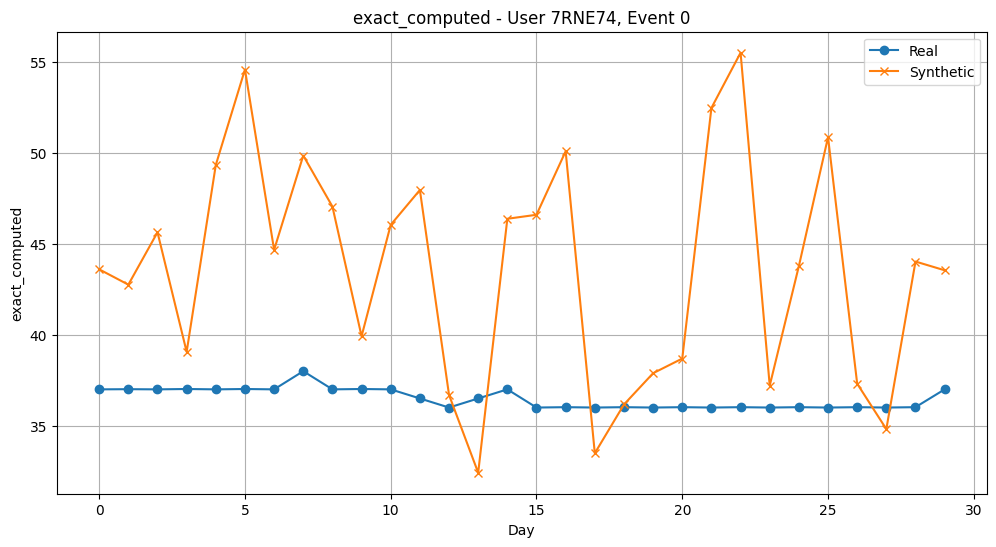

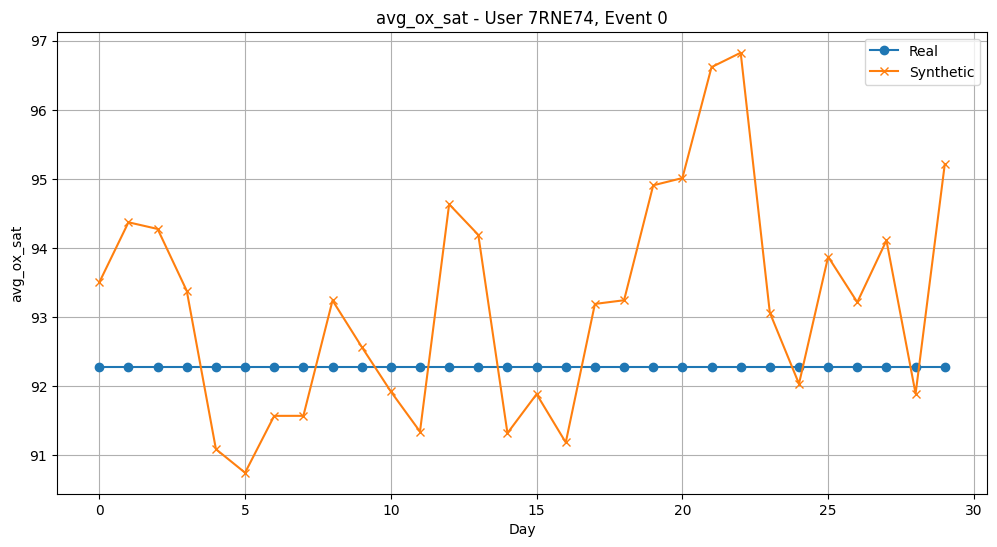

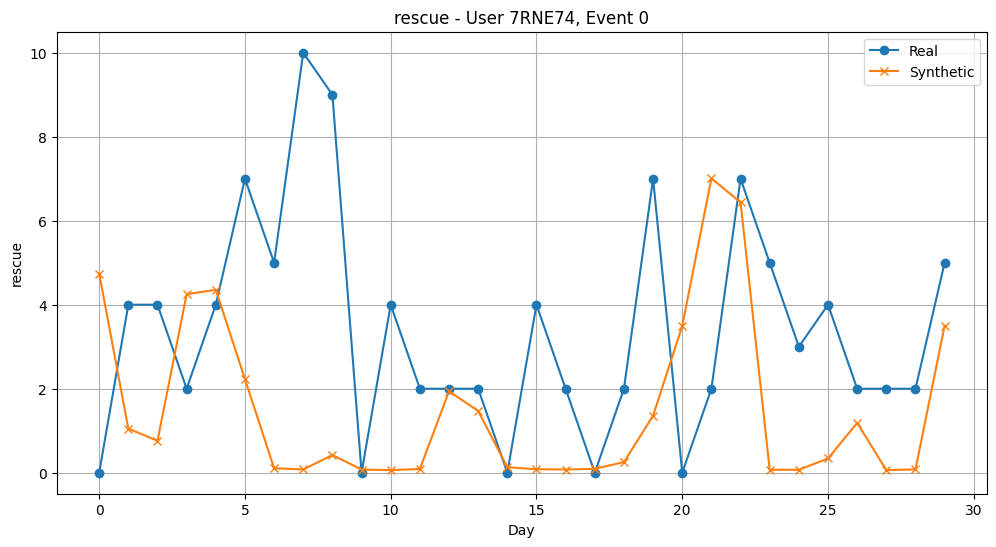

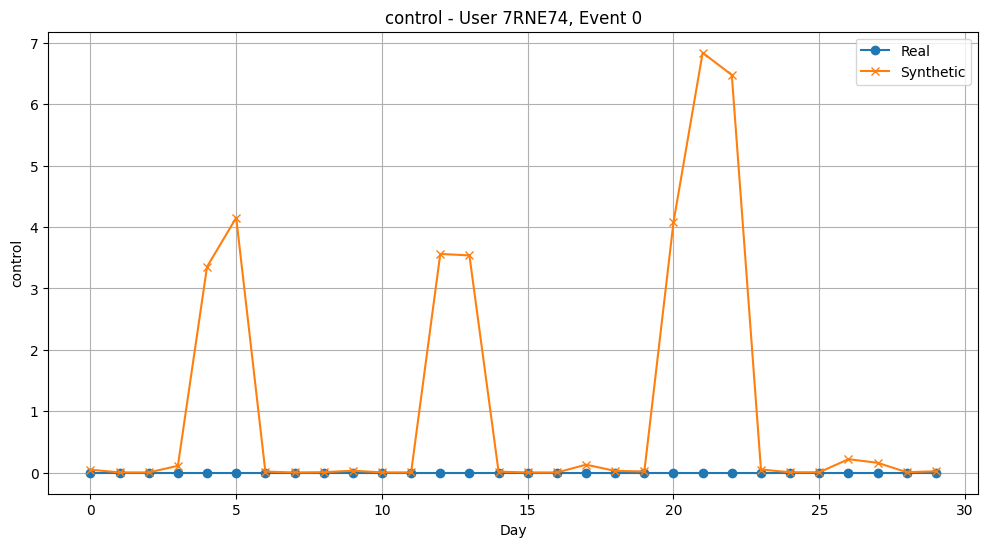

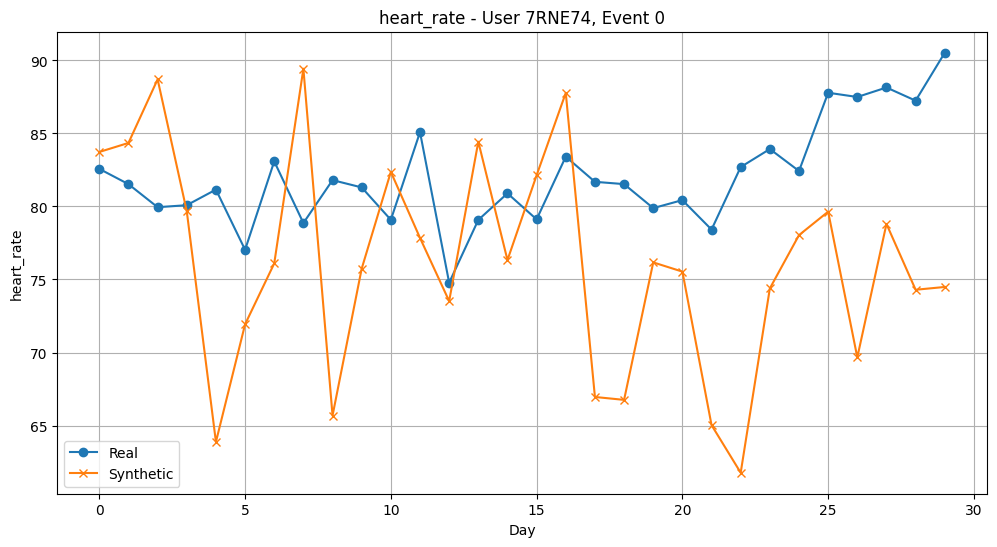

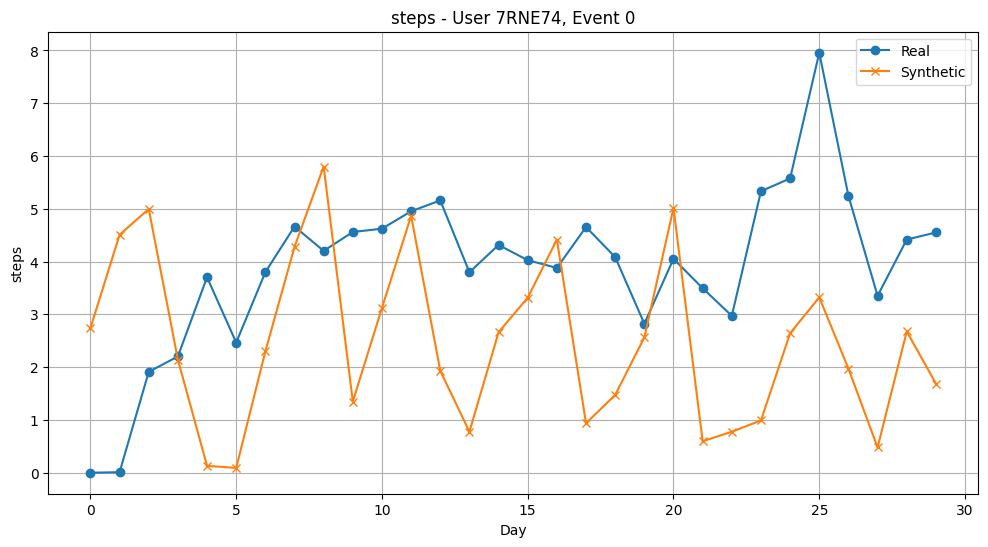

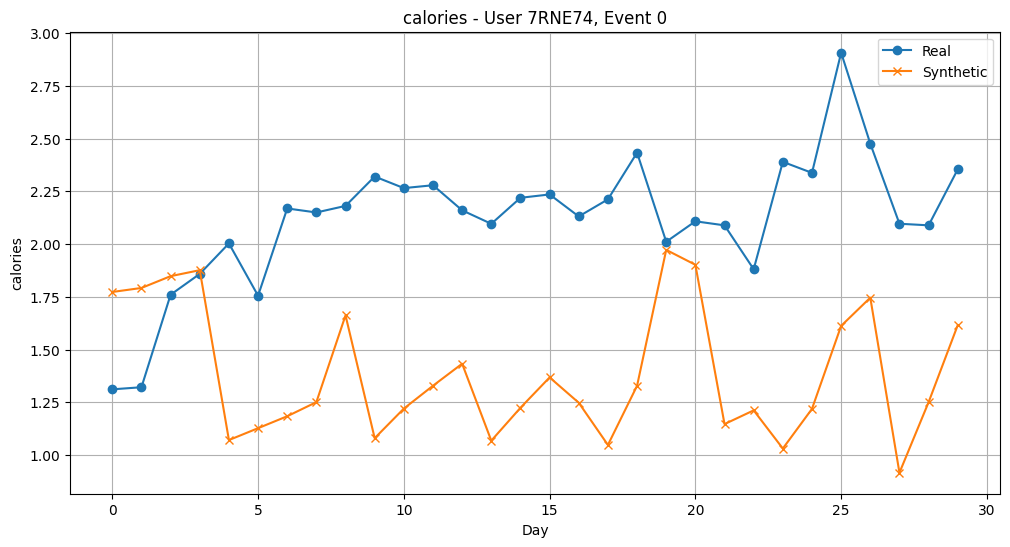

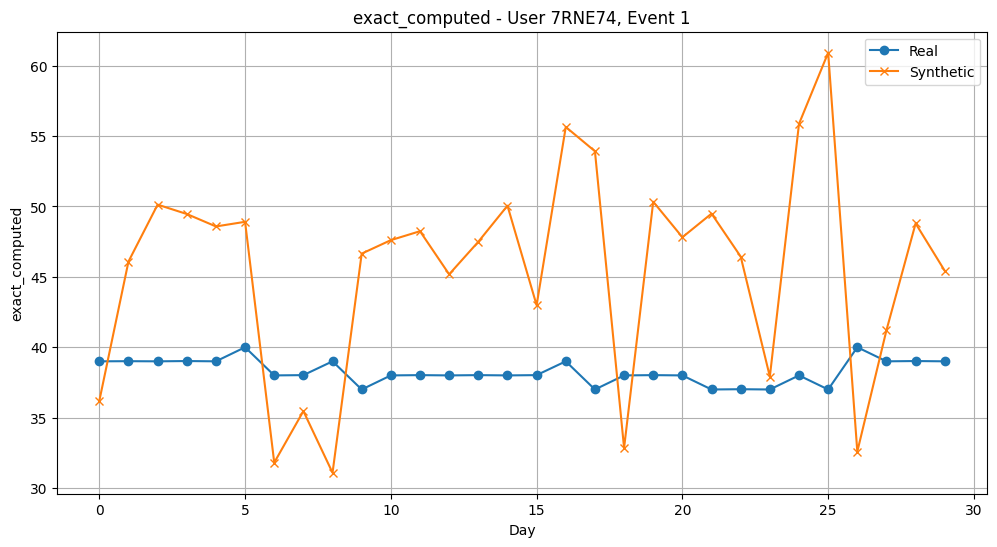

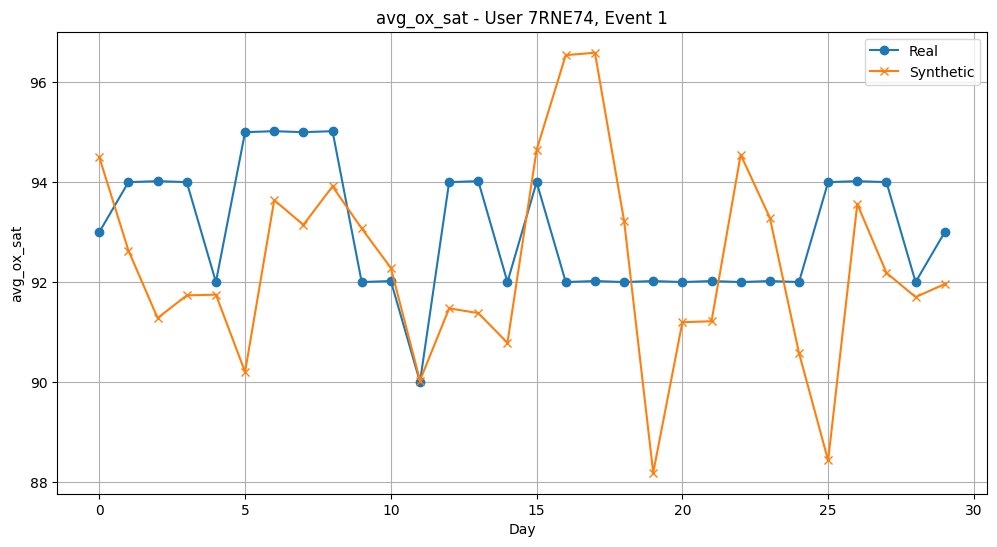

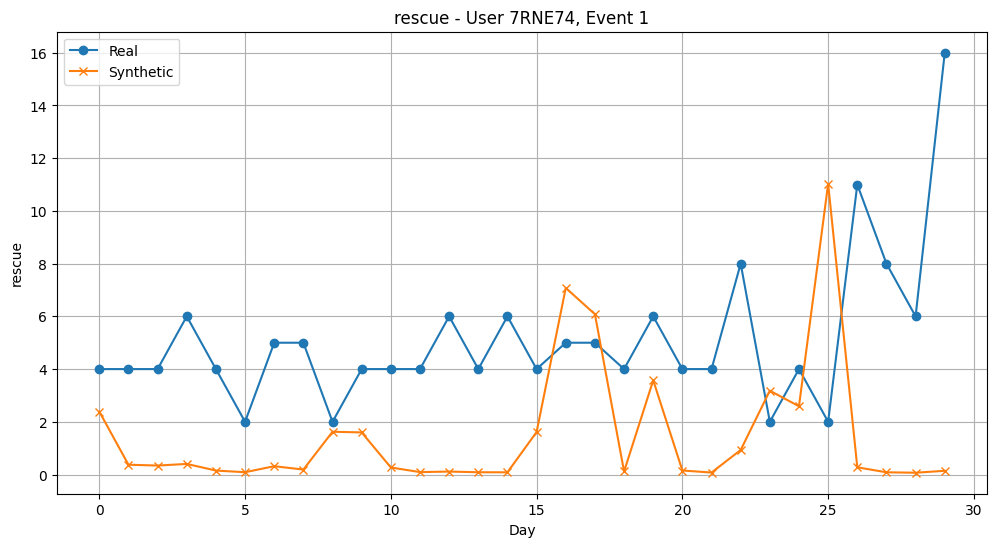

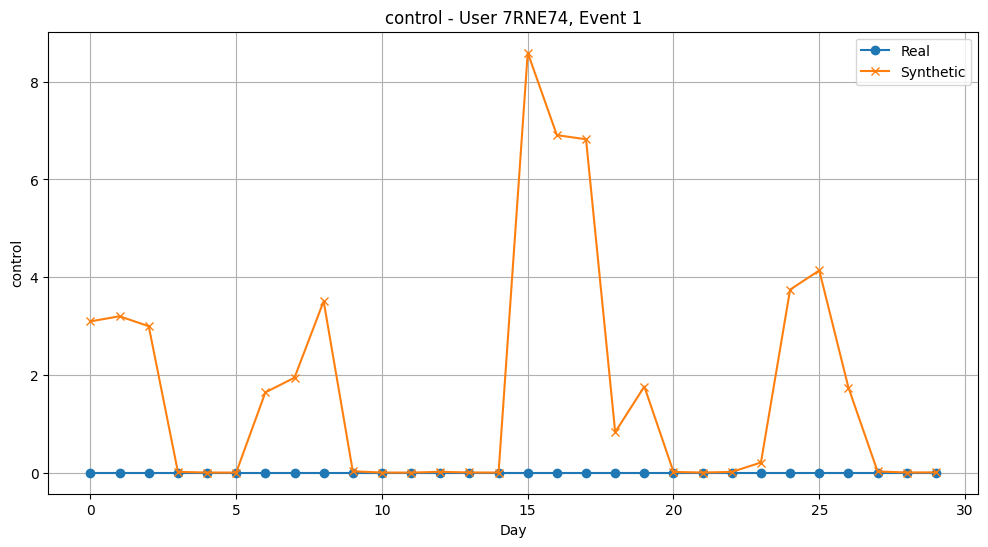

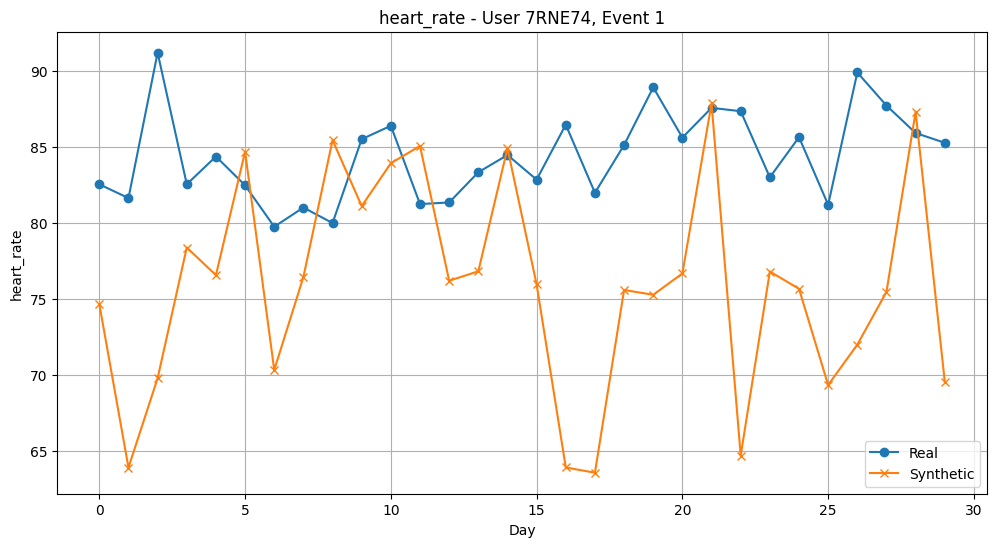

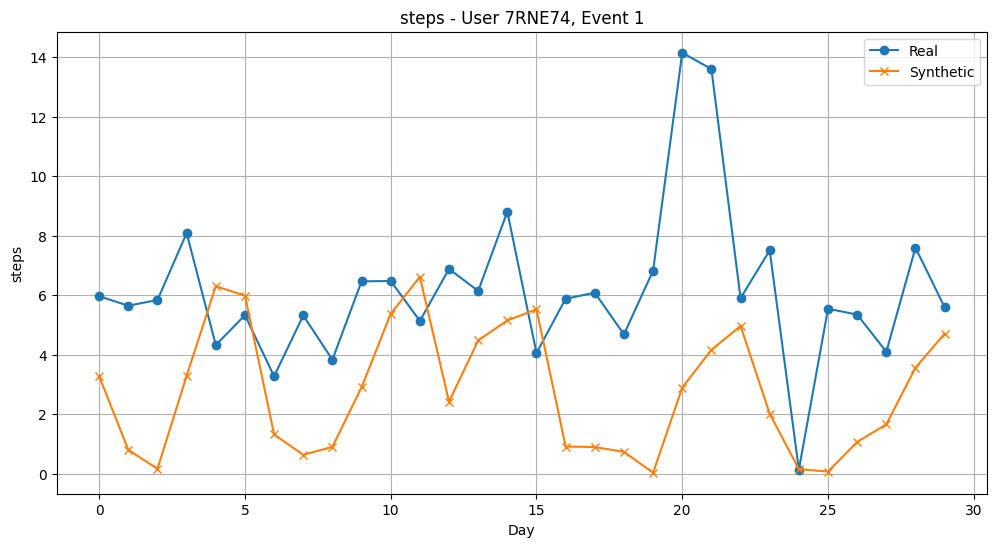

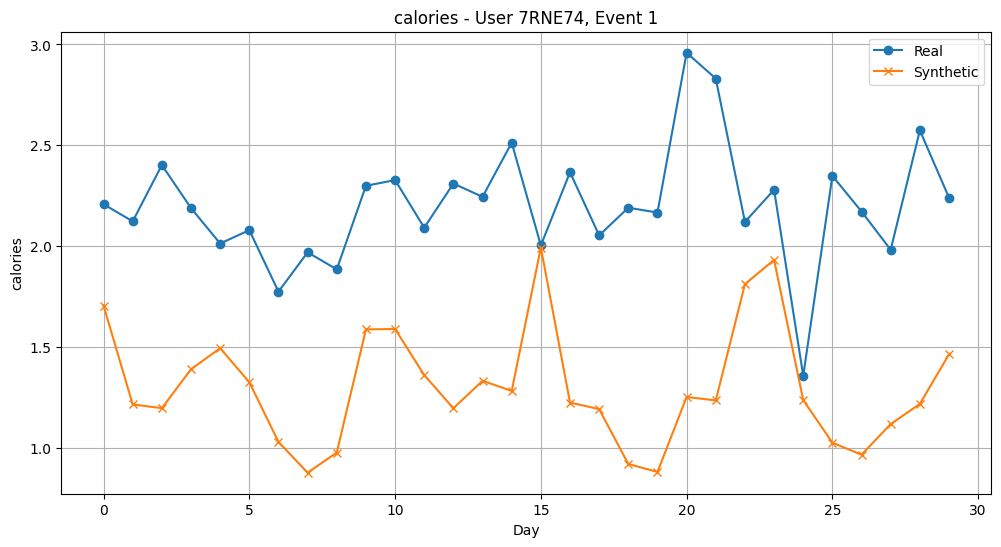

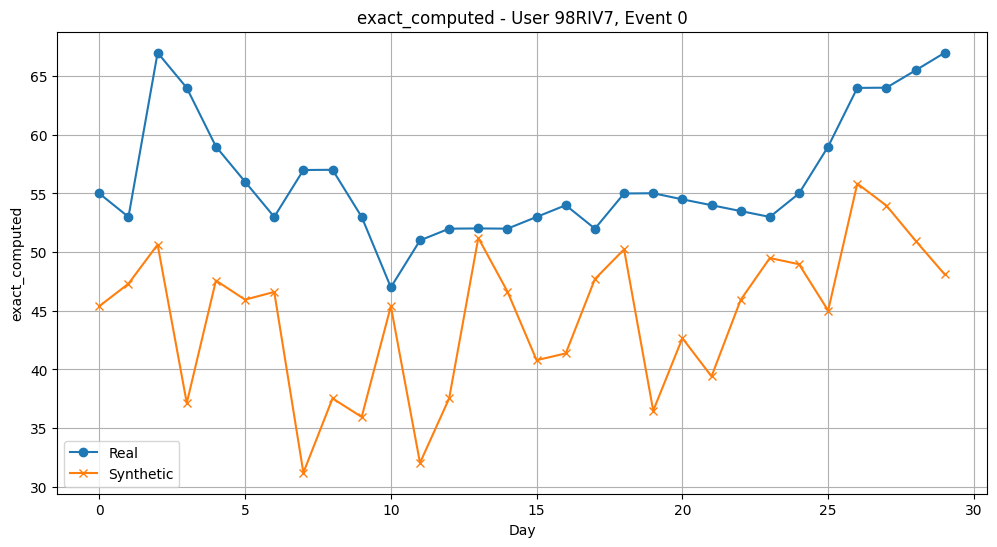

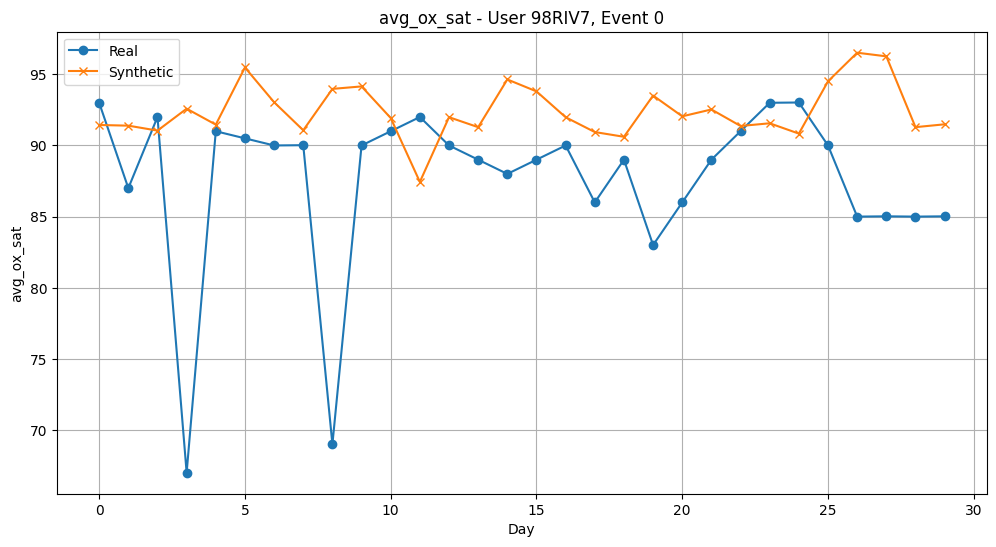

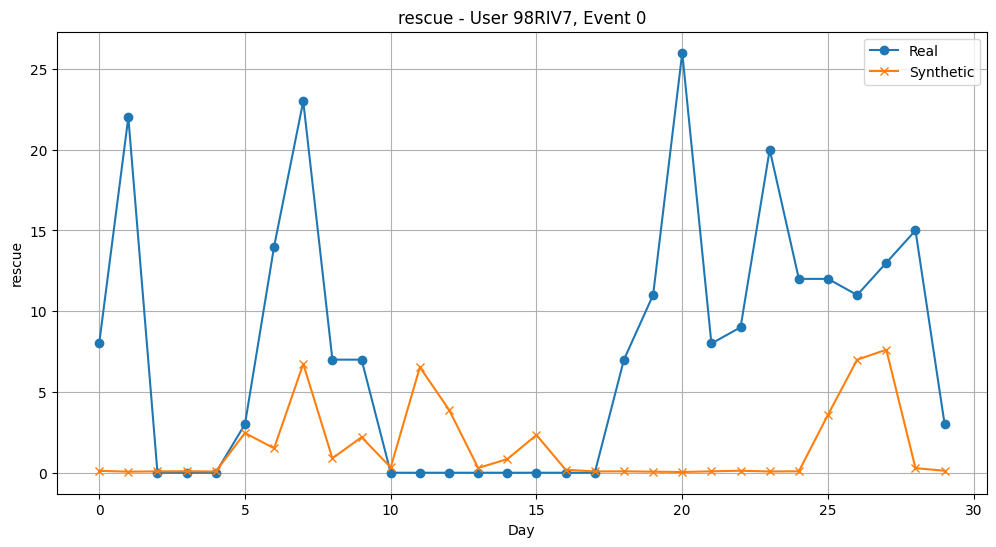

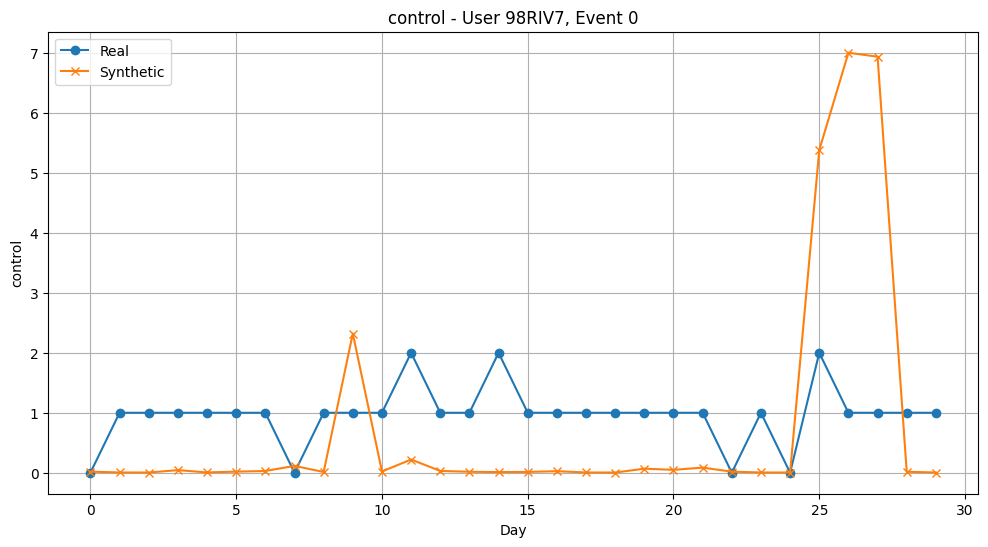

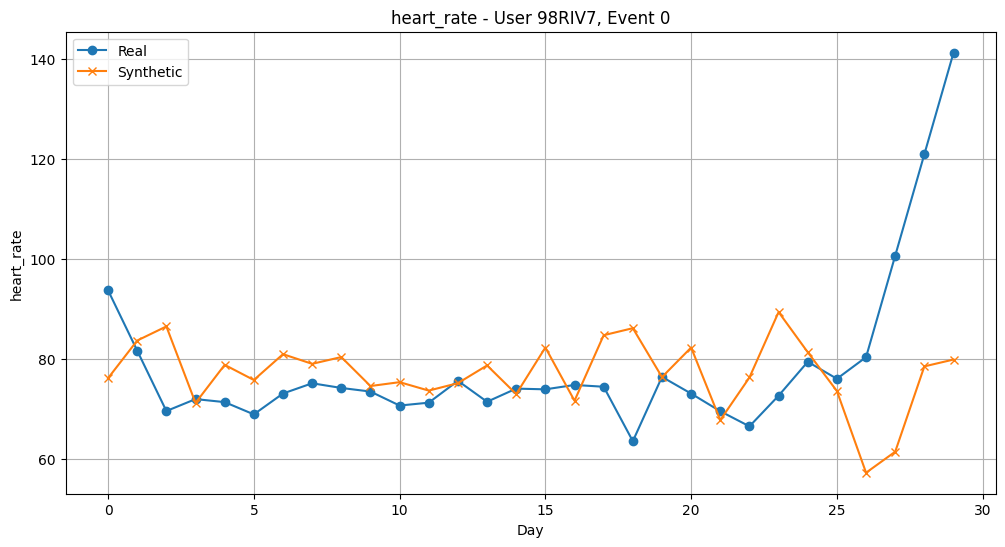

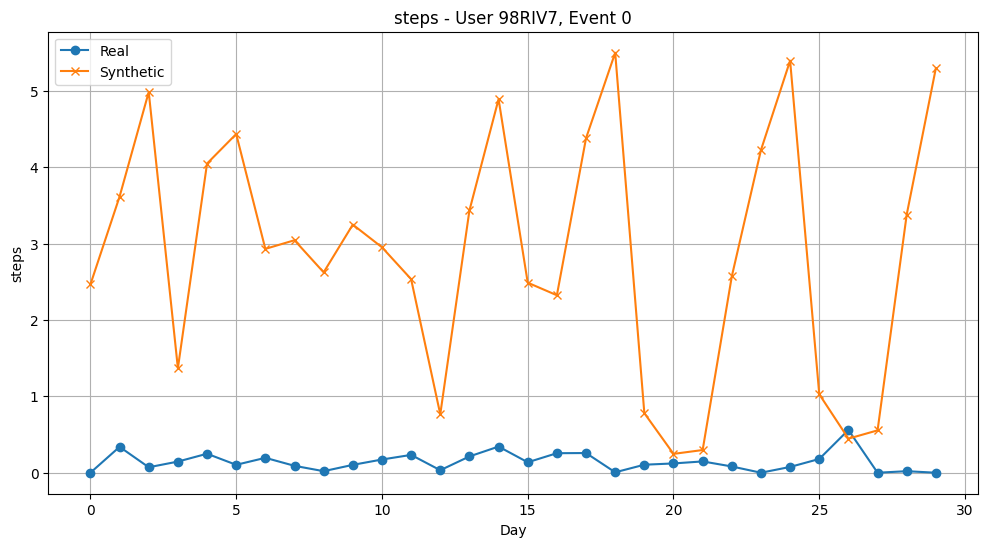

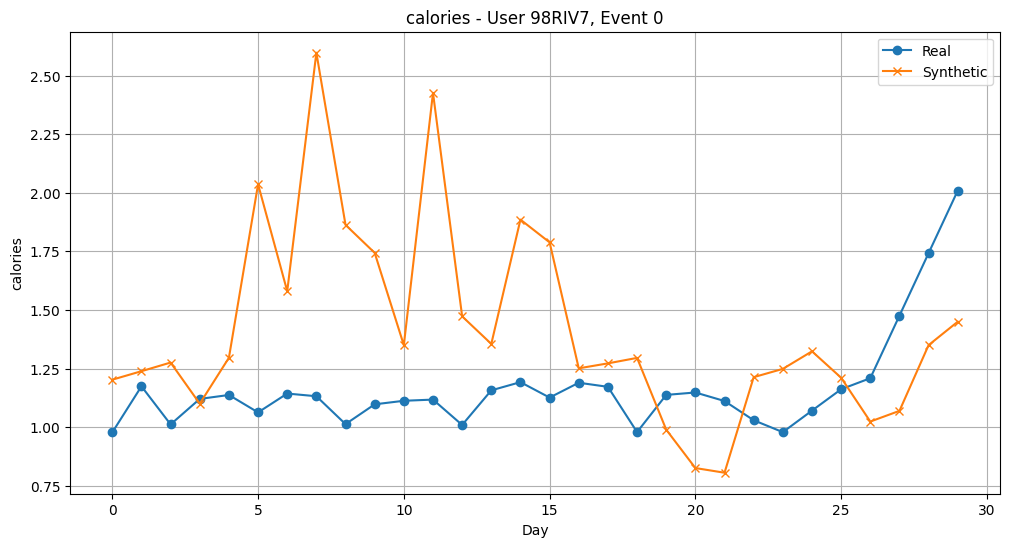

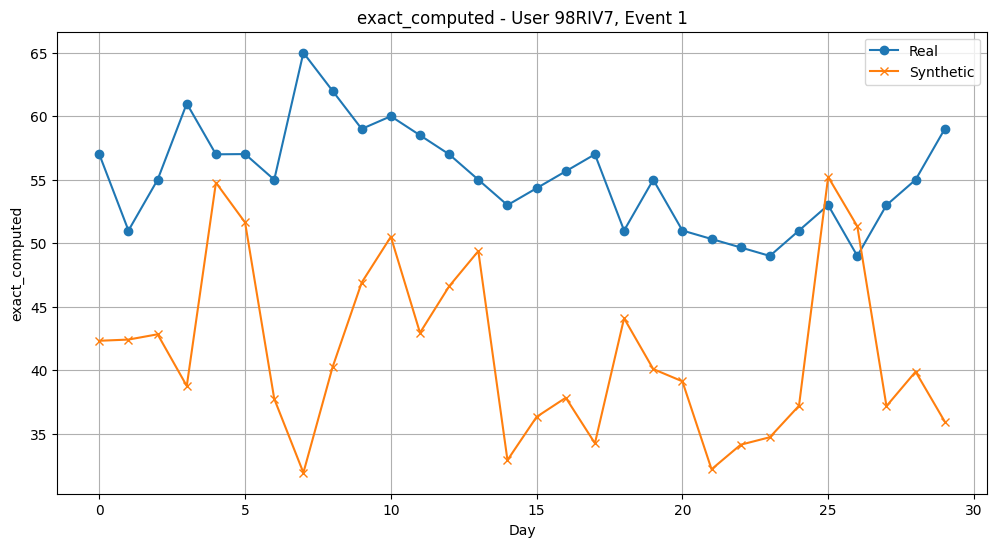

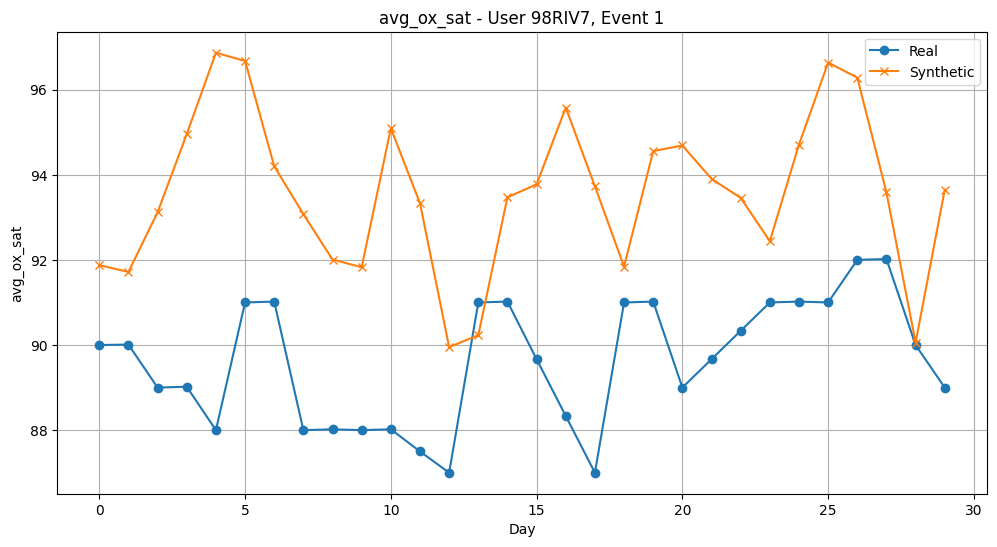

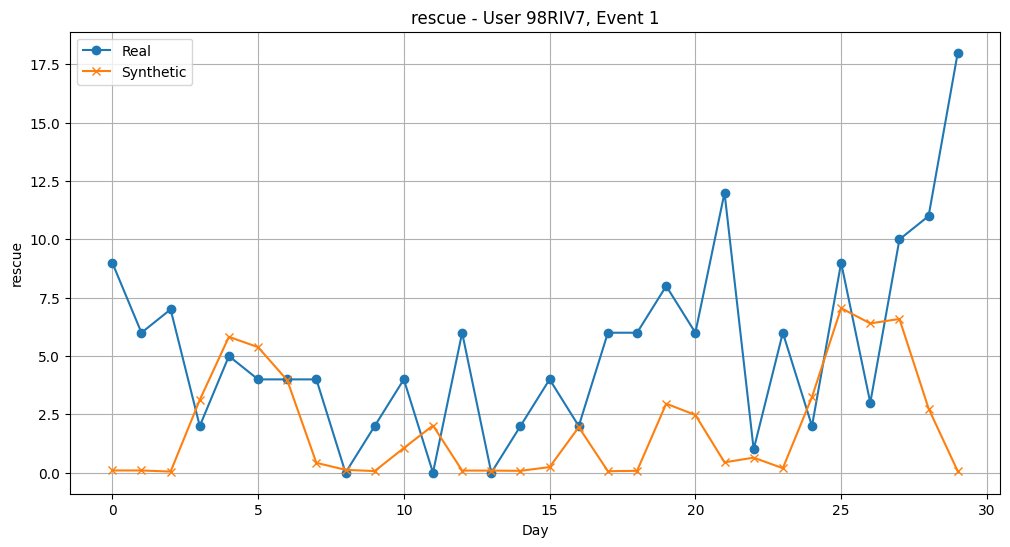

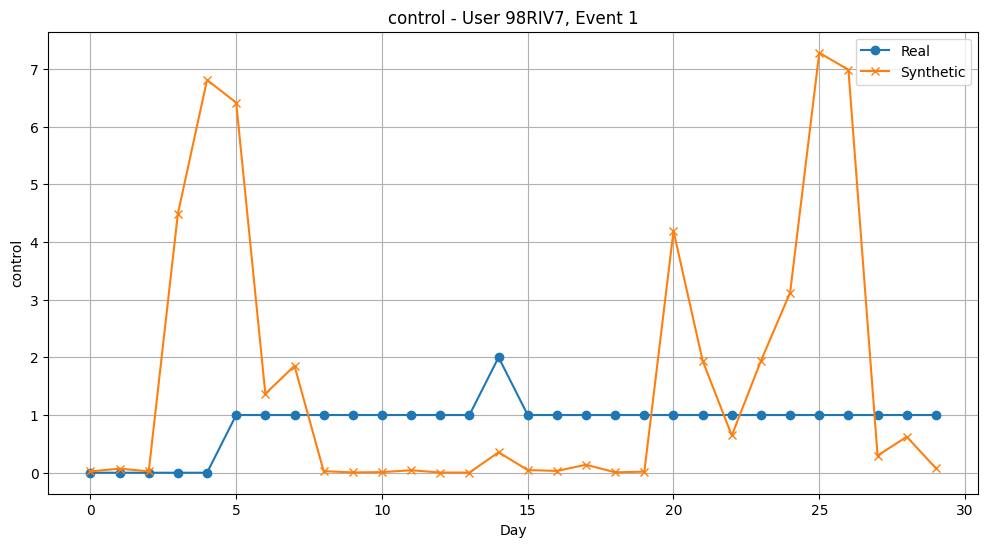

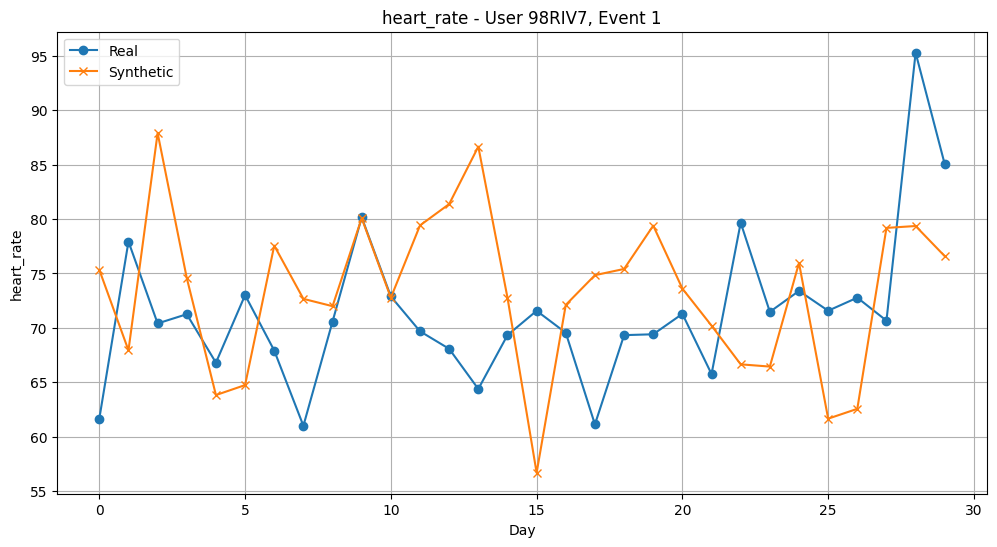

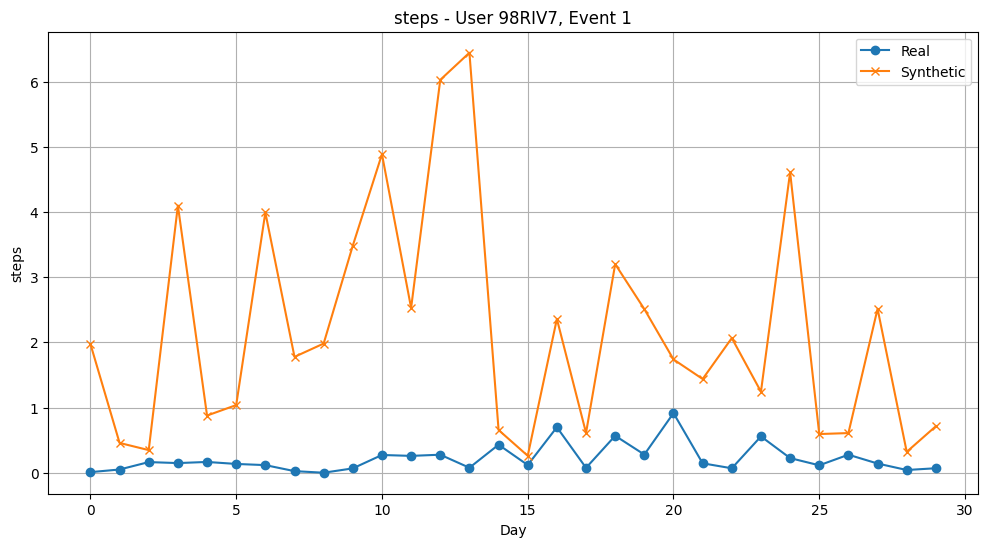

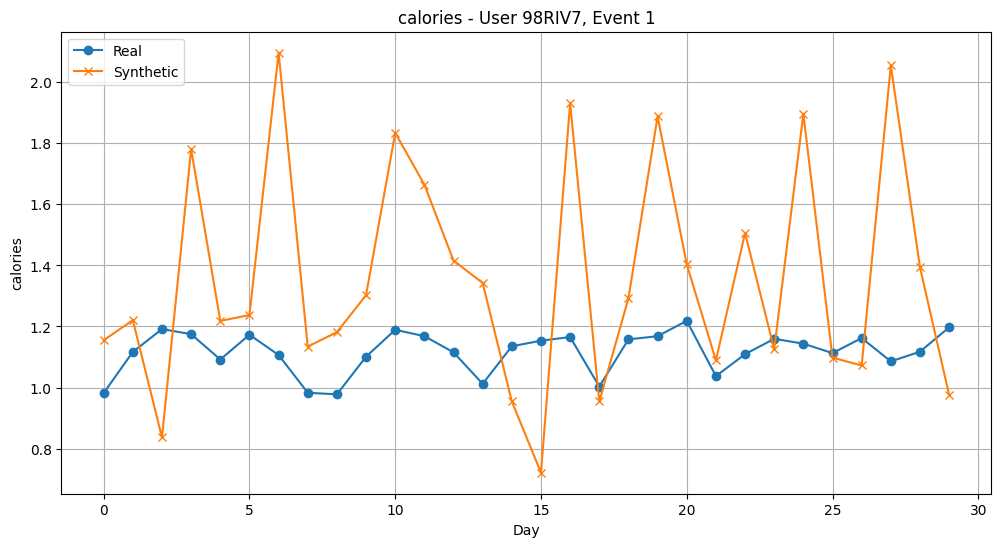

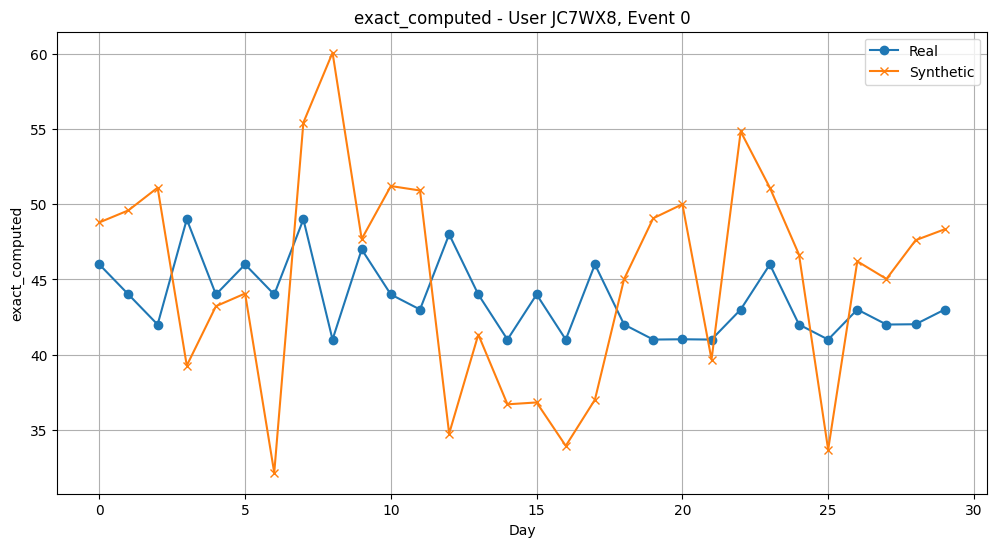

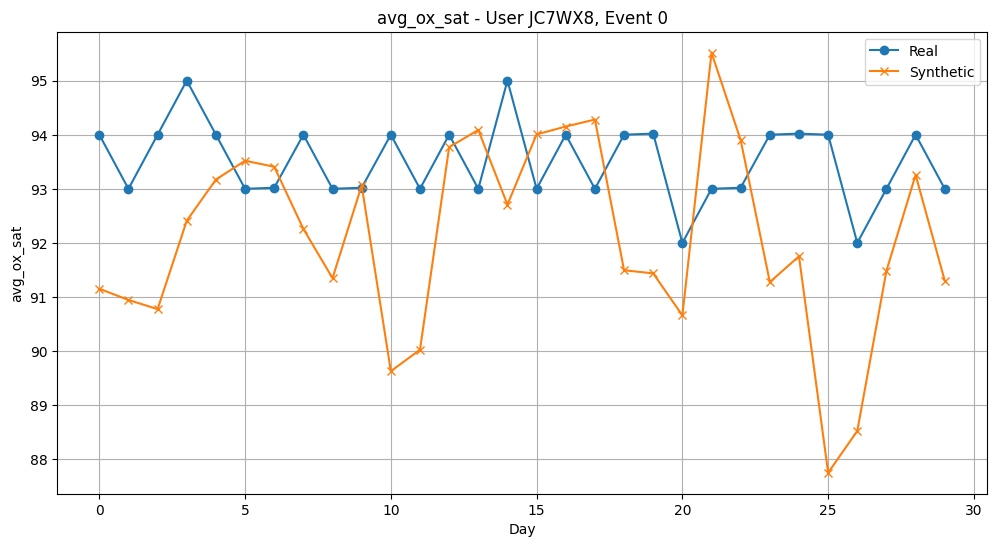

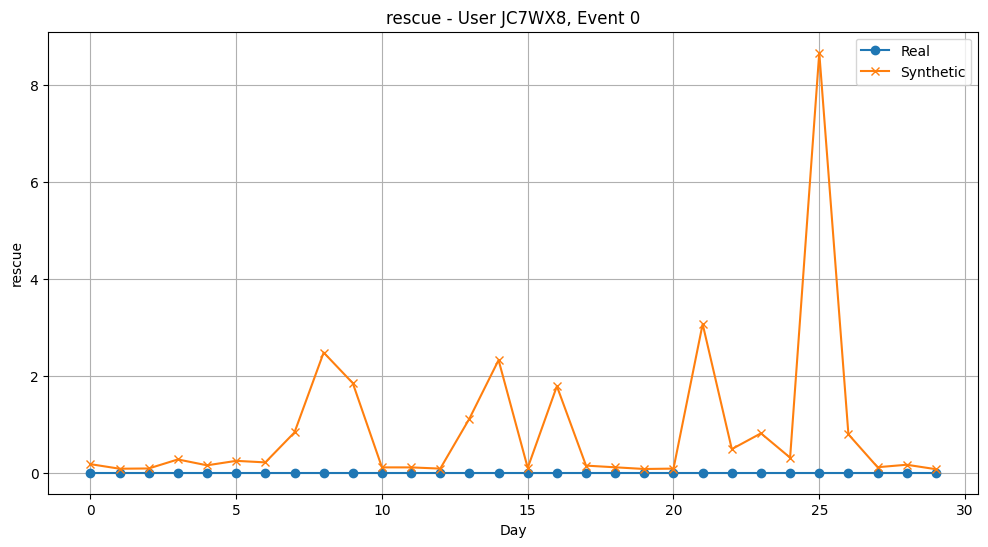

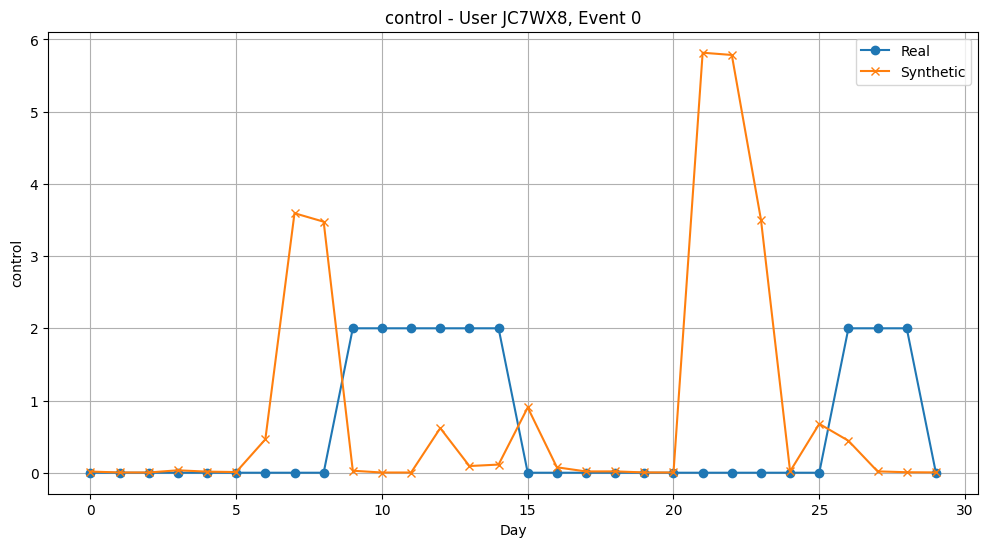

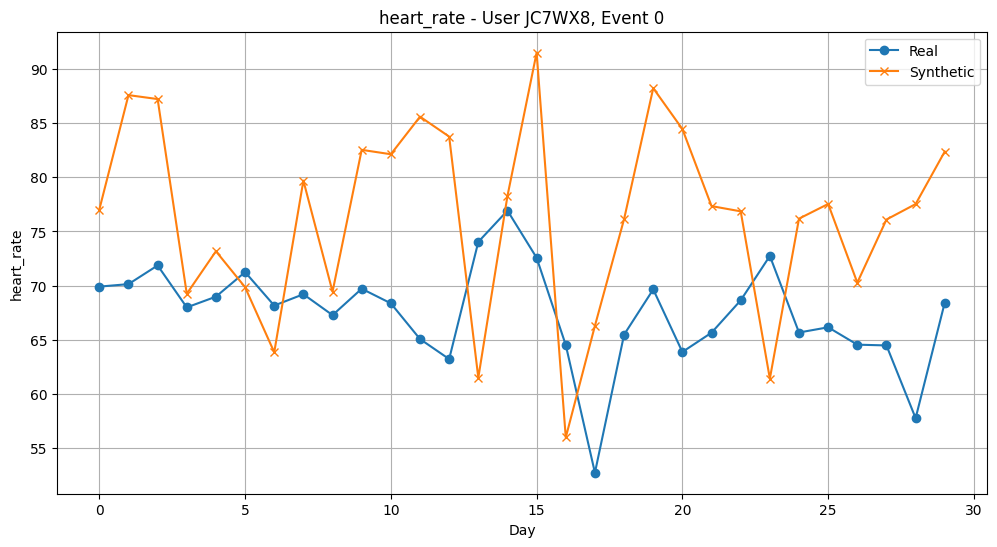

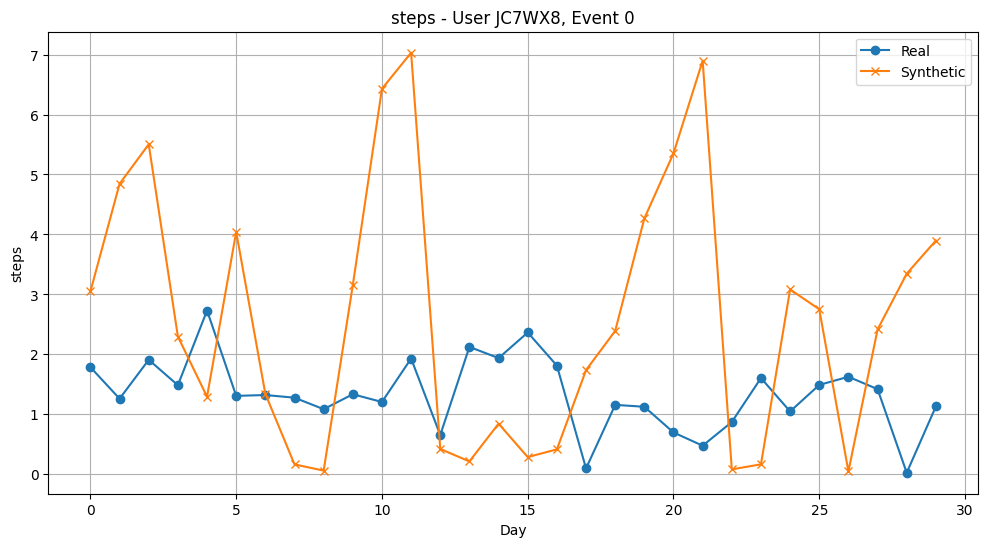

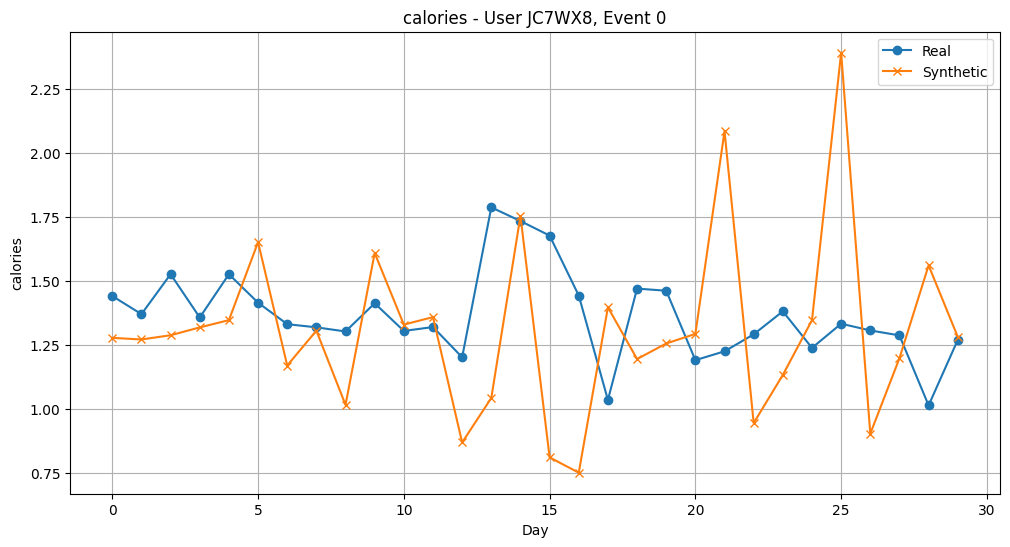

In [ ]:
# Plot examples
all_synthetic_data = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')
for i in range(min(5, len(processed_data))):
    user, event, real_data = processed_data[i]
    synthetic_user_event = get_synthetic_data(all_synthetic_data, user, event)

    real_df = pd.DataFrame(real_data, columns=features)

    for feature in features:
        plot_real_vs_synthetic(real_df, synthetic_user_event, feature, user, event)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Load the data
real_data = pd.read_csv('data_without_scaling/interpolated_exacerbation_data.csv')
synthetic_data = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')

### PCA and TSNE

In [ ]:
# Prepare data for PCA and t-SNE
real_sample = real_data[features].values
synthetic_sample = synthetic_data[features].values

# Combine real and synthetic data
combined_data = np.vstack((real_sample, synthetic_sample))

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_data)

# Perform t-SNE
tsne = TSNE(n_components=2, n_iter=3000, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# Separate results for real and synthetic data
pca_real = pca_results[:len(real_sample)]
pca_synthetic = pca_results[len(real_sample):]
tsne_real = tsne_results[:len(real_sample)]
tsne_synthetic = tsne_results[len(real_sample):]

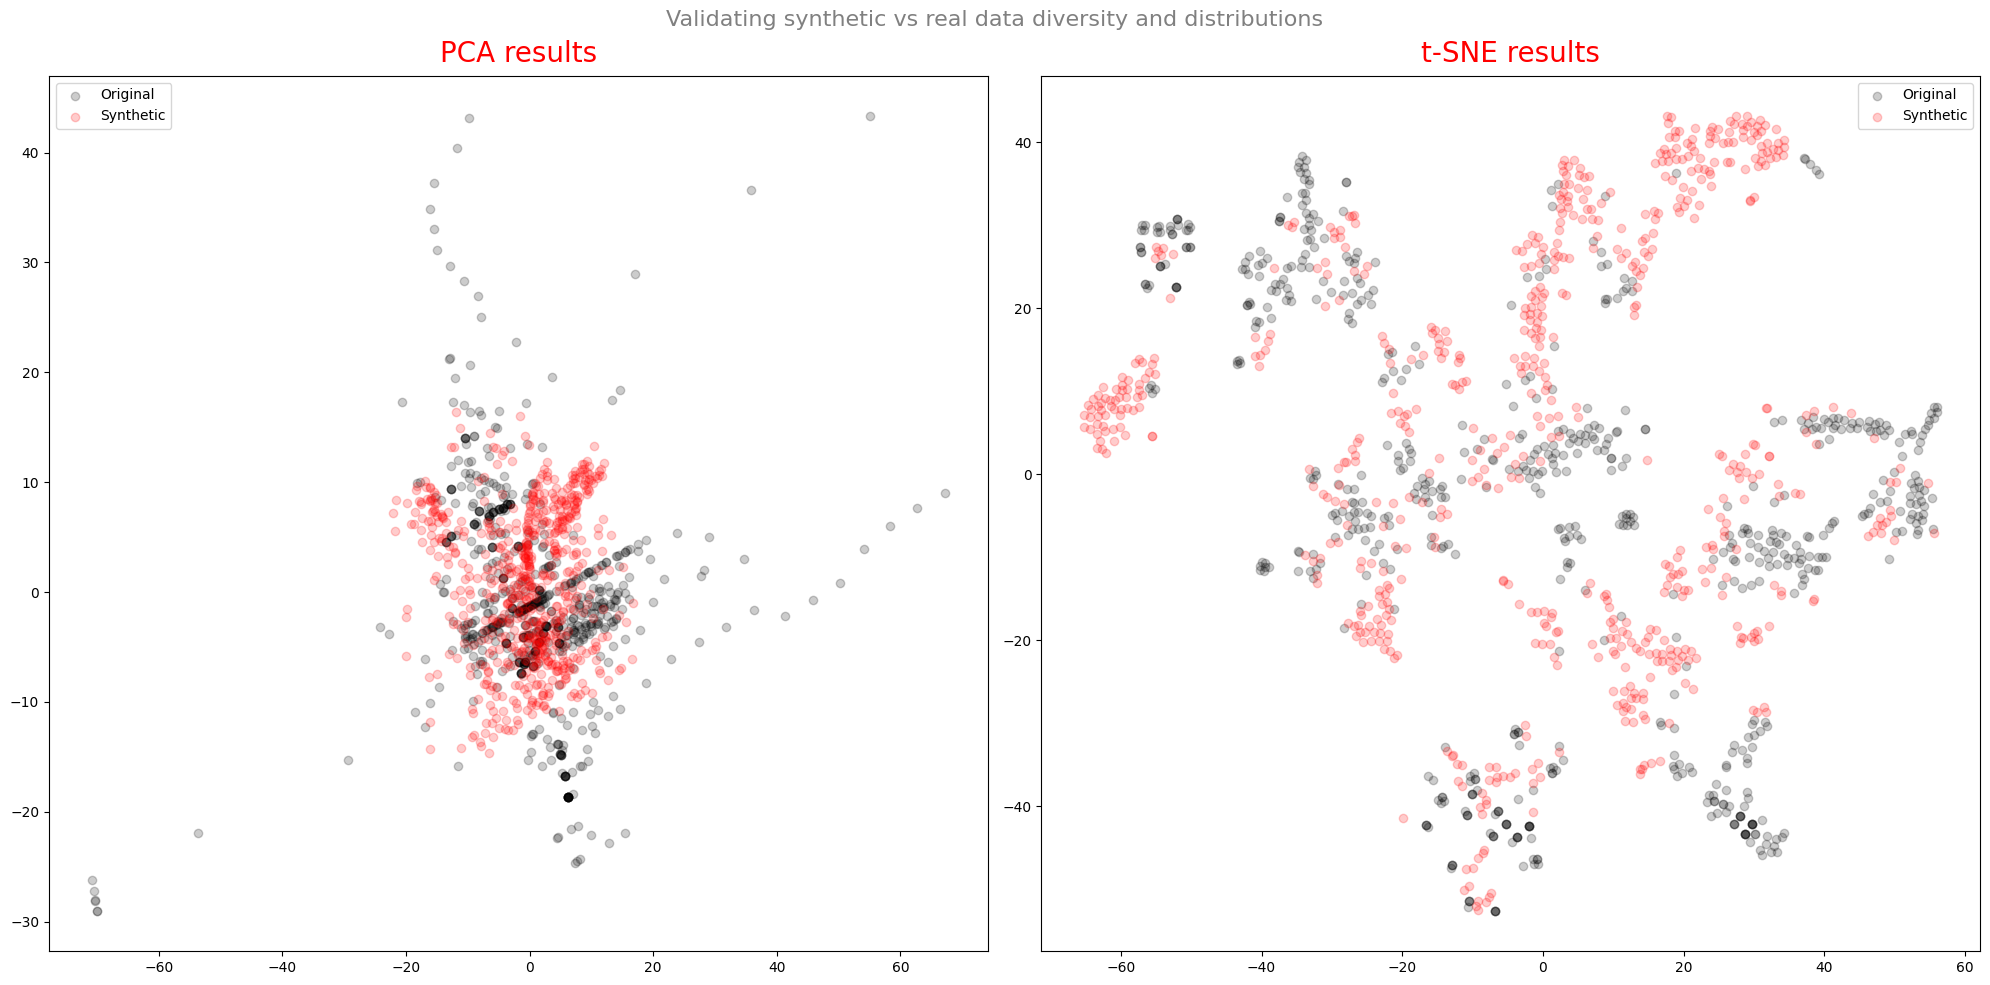

In [ ]:
# Plotting
plt.figure(figsize=(20, 10))

# PCA plot
plt.subplot(1, 2, 1)
plt.scatter(pca_real[:, 0], pca_real[:, 1], c='black', alpha=0.2, label='Original')
plt.scatter(pca_synthetic[:, 0], pca_synthetic[:, 1], c='red', alpha=0.2, label='Synthetic')
plt.title('PCA results', fontsize=20, color='red', pad=10)
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
plt.scatter(tsne_real[:, 0], tsne_real[:, 1], c='black', alpha=0.2, label='Original')
plt.scatter(tsne_synthetic[:, 0], tsne_synthetic[:, 1], c='red', alpha=0.2, label='Synthetic')
plt.title('t-SNE results', fontsize=20, color='red', pad=10)
plt.legend()

plt.suptitle('Validating synthetic vs real data diversity and distributions', fontsize=16, color='grey')
plt.tight_layout()
plt.show()

### Metrics

In [ ]:
# Prepare the data
def prepare_data(df, seq_len=30):
    data = df[features].values
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len-1])
        y.append(data[i+seq_len-1])
    return np.array(X), np.array(y)

In [ ]:
X_real, y_real = prepare_data(real_data)
X_synth, y_synth = prepare_data(synthetic_data)

In [ ]:
# Split the real data into train and test sets
X_train_real, X_test, y_train_real, y_test = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

In [ ]:
# Define the RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=True),
        GRU(32),
        Dense(len(features))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
# Train the model on real data
model_real = create_rnn_model((X_train_real.shape[1], X_train_real.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
real_train = model_real.fit(X_train_real, y_train_real, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [ ]:
# Train the model on synthetic data
model_synth = create_rnn_model((X_synth.shape[1], X_synth.shape[2]))
synth_train = model_synth.fit(X_synth, y_synth, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [ ]:
# Make predictions
y_pred_real = model_real.predict(X_test)
y_pred_synth = model_synth.predict(X_test)

4/4 [==============================] - 1s 9ms/step


In [ ]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return r2, mae, mse

In [ ]:
metrics_real = calculate_metrics(y_test, y_pred_real)
metrics_synth = calculate_metrics(y_test, y_pred_synth)

In [ ]:
# Print results
print("Metrics for model trained on real data:")
print(f"R2 Score: {metrics_real[0]}")
print(f"Mean Absolute Error: {metrics_real[1]}")
print(f"Mean Squared Error: {metrics_real[2]}")

print("\nMetrics for model trained on synthetic data:")
print(f"R2 Score: {metrics_synth[0]}")
print(f"Mean Absolute Error: {metrics_synth[1]}")
print(f"Mean Squared Error: {metrics_synth[2]}")

Metrics for model trained on real data:
R2 Score: -0.2255768783172009
Mean Absolute Error: 3.402709662854253
Mean Squared Error: 43.124566221831735

Metrics for model trained on synthetic data:
R2 Score: -0.026817329749155152
Mean Absolute Error: 3.445529027846249
Mean Squared Error: 53.01663746174395


In [ ]:
def compare_data(real, synthetic):
    r2_scores = []
    mae_scores = []
    msle_scores = []

    # Get the minimum length across all features for both real and synthetic data
    min_real_len = min(len(real[feature]) for feature in features)
    min_synth_len = min(len(synthetic[feature]) for feature in features)
    min_len = min(min_real_len, min_synth_len)

    for feature in features:
        # Slice the real and synthetic data to the minimum length
        real_feature = real[feature].to_numpy()[:min_len]
        synth_feature = synthetic[feature].to_numpy()[:min_len]

        r2 = r2_score(real_feature.flatten(), synth_feature.flatten())
        mae = mean_absolute_error(real_feature.flatten(), synth_feature.flatten())
        msle = mean_squared_log_error(real_feature.flatten(), synth_feature.flatten())

        r2_scores.append(r2)
        mae_scores.append(mae)
        msle_scores.append(msle)

    return r2_scores, mae_scores, msle_scores

In [ ]:
r2_scores, mae_scores, msle_scores = compare_data(real_data[features], synthetic_data[features])

In [ ]:
print("R2 Scores:")
for feature, score in zip(features, r2_scores):
    print(f"{feature}: {score:.4f}")

print("\nMean Absolute Error:")
for feature, score in zip(features, mae_scores):
    print(f"{feature}: {score:.4f}")

print("\nMean Squared Log Error:")
for feature, score in zip(features, msle_scores):
    print(f"{feature}: {score:.4f}")

R2 Scores:
exact_computed: -0.5771
avg_ox_sat: -0.1942
rescue: -0.5796
control: -0.9353
heart_rate: -0.3337
steps: -0.7648
calories: -0.7660

Mean Absolute Error:
exact_computed: 9.8459
avg_ox_sat: 2.7419
rescue: 2.5462
control: 2.2404
heart_rate: 9.5771
steps: 2.1727
calories: 0.4566

Mean Squared Log Error:
exact_computed: 0.0860
avg_ox_sat: 0.0031
rescue: 1.2039
control: 1.1626
heart_rate: 0.1979
steps: 0.7326
calories: 0.0621


# KMeans and LSTM

In [ ]:
!pip install shap==0.45.1
!pip install tensorflow==2.10.0
!pip install keras==2.10.0

  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.1 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)


In [ ]:
cd /content/drive/MyDrive/Project\ Capp/

/content/drive/MyDrive/Project Capp


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import pickle

In [ ]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import shap

def plot_shap_summary(shap_values, X, feature_names):
    shap.summary_plot(shap_values, X, plot_type="bar", feature_names=feature_names)

def plot_shap_force(shap_values, X, feature_names):
    shap.force_plot(shap.Explanation(values=shap_values[0],
                                     base_values=np.zeros(shap_values[0].shape[0]),
                                     data=X[0],
                                     feature_names=feature_names))

# Synthetic Data

In [ ]:
# Load the synthetic data
synthetic_data = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')

# Define features
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
synthetic_data

exact_computed  avg_ox_sat    rescue   control  heart_rate     steps  \
0         43.603054   93.498055  4.742512  0.049214   83.732785  2.741474   
1         42.759151   94.368460  1.050426  0.005034   84.352054  4.508067   
2         45.639998   94.272157  0.760384  0.004327   88.708323  4.996969   
3         39.062746   93.375881  4.249915  0.112311   79.671635  2.141738   
4         49.343437   91.082375  4.354613  3.353970   63.876182  0.130031   
..              ...         ...       ...       ...         ...       ...   
655       39.453708   92.127586  0.150733  0.030040   70.332294  2.035344   
656       46.331068   92.789073  0.107620  0.007757   79.087877  2.437473   
657       45.336417   95.542751  2.339088  0.018713   74.295221  4.419948   
658       34.397788   93.630987  0.065871  0.124928   74.008470  0.648773   
659       37.306971   95.263213  0.117597  0.098325   78.462851  0.254098   

     calories      id  event_id  study_day  
0    1.772821  7RNE74         0          1  
1    1.791906  7RNE74         0          2  
2    1.847836  7RNE74         0          3  
3    1.876255  7RNE74         0          4  
4    1.070455  7RNE74         0          5  
..        ...     ...       ...        ...  
655  1.210169  XKCKIT         2         26  
656  1.444854  XKCKIT         2         27  
657  2.027576  XKCKIT         2         28  
658  0.964599  XKCKIT         2         29  
659  0.804411  XKCKIT         2         30  

[660 rows x 10 columns]

In [ ]:
# Prepare data for patient-level analysis
def prepare_patient_level_data(data):
    patient_level_data = []
    for (user, event), group in data.groupby(['id', 'event_id']):
        patient_level_data.append(group[features].values)
    return np.array(patient_level_data)

X_train_patient_level = prepare_patient_level_data(synthetic_data)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_patient_level_2d = X_train_patient_level.reshape(-1, X_train_patient_level.shape[-1])
X_train_patient_level_2d_scaled = scaler.fit_transform(X_train_patient_level_2d)
X_train_patient_level_scaled = X_train_patient_level_2d_scaled.reshape(X_train_patient_level.shape)

In [ ]:
#X_train_patient_level_scaled

In [ ]:
len(X_train_patient_level_scaled[0])

30

In [ ]:
# Load the pre-trained LSTM autoencoder
autoencoder = load_model('lstm_autoencoder.h5')

# Create the encoder model - layer[3] output
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[3].output)

# LSTM Autoencoder for dimensionality reduction before applying KMeans clustering
encoded_vecs_patient_level = encoder.predict(X_train_patient_level_scaled)
encoded_vecs_patient_level

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[1.27669935e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01850018e-01, 1.33363664e-01, 0.00000000e+00, 5.35093294e-03],
       [9.23830896e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.12383366e-01, 1.33118123e-01, 0.00000000e+00, 1.14363991e-02],
       [6.86321187e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.08510680e-01, 1.33283779e-01, 0.00000000e+00, 1.00669218e-02],
       [6.82556163e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.03110865e-01, 1.42018870e-01, 0.00000000e+00, 4.96537844e-03],
       [7.63550787e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.02339491e-01, 1.36510000e-01, 0.00000000e+00, 9.11035761e-03],
       [5.13780911e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.03700832e-01, 1.35299668e-01, 0.00000000e+00, 5.32073388e-03],
       [6.59090006e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01583332e-01, 1.39862835e-01, 0.00000000e+00, 2.

In [ ]:
# Save StandardScaler object
pickle.dump(scaler, open('checkpoints/synthetic_data_scaler.pkl', 'wb'))

In [ ]:
def perform_kmeans_clustering(max_clusters=7):
    sum_of_squared_distances = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)

    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        # km = km.fit(data.reshape(data.shape[0], -1))
        # Fit the KMeans clustering object to the encoded patient-level data
        km = km.fit(encoded_vecs_patient_level)
        sum_of_squared_distances.append(km.inertia_)
        # silhouette_scores.append(silhouette_score(data.reshape(data.shape[0], -1), km.labels_))
        # Calculate and append the silhouette score
        silhouette_scores.append(silhouette_score(encoded_vecs_patient_level, km.labels_))

    # Plot elbow curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return K[np.argmax(silhouette_scores)]

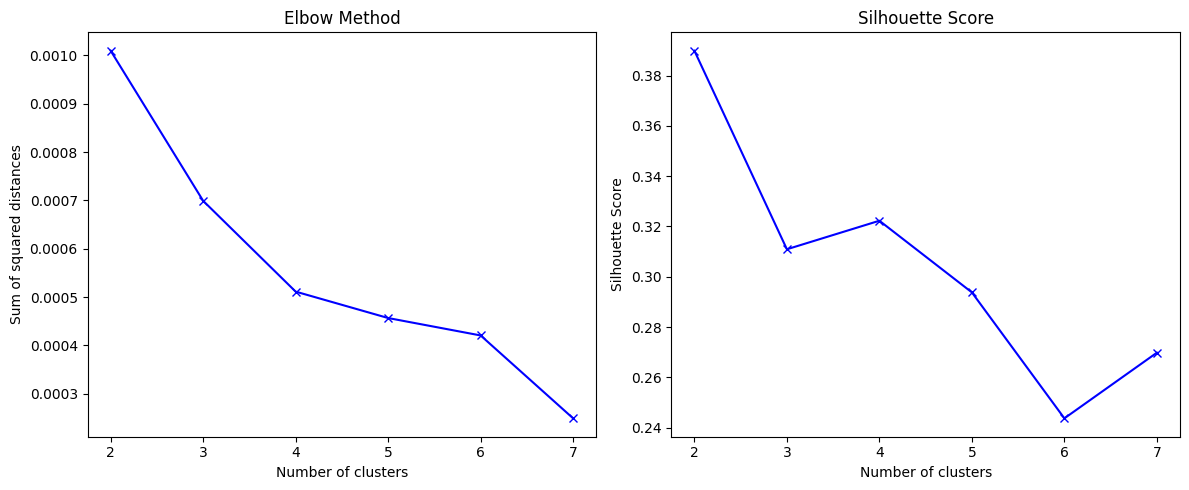

Optimal number of clusters: 2


In [ ]:
# Perform KMeans clustering
optimal_clusters = perform_kmeans_clustering()
print(f"Optimal number of clusters: {optimal_clusters}")

km_synthetic= KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = km_synthetic.fit_predict(X_train_patient_level_scaled.reshape(X_train_patient_level_scaled.shape[0], -1))

# Get cluster centroids and labels
synthetic_centroids = km_synthetic.cluster_centers_
synthetic_labels = km_synthetic.labels_

In [ ]:
synthetic_centroids

In [ ]:
synthetic_labels

In [ ]:
cluster_labels

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
      dtype=int32)

In [ ]:
# LSTM Model
def create_lstm_model(input_shape, n_clusters):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(8, activation='relu'),
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(n_clusters, activation='softmax' if n_clusters > 2 else 'sigmoid')
    ])

    optimizer = SGD(learning_rate=0.01, momentum=0.5, clipvalue=1.0)
    model.compile(loss='sparse_categorical_crossentropy' if n_clusters > 2 else 'binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Create and train LSTM model
lstm_model = create_lstm_model((X_train_patient_level_scaled.shape[1], X_train_patient_level_scaled.shape[2]), optimal_clusters)

# One-hot encode the cluster labels
cluster_labels_onehot = to_categorical(cluster_labels)

history = lstm_model.fit(X_train_patient_level_scaled, cluster_labels_onehot, batch_size=32, epochs=100, validation_split=0.2)

Train on 17 samples, validate on 5 samples
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6939 - acc: 0.3529

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


17/17 [==============================] - 1s 57ms/sample - loss: 0.6939 - acc: 0.3529 - val_loss: 0.6940 - val_acc: 0.4000
Epoch 2/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6936 - acc: 0.3824 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 3/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6924 - val_acc: 0.6000
Epoch 4/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6928 - acc: 0.5000 - val_loss: 0.6915 - val_acc: 0.8000
Epoch 5/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6924 - acc: 0.6471 - val_loss: 0.6908 - val_acc: 0.8000
Epoch 6/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6920 - acc: 0.6471 - val_loss: 0.6899 - val_acc: 0.8000
Epoch 7/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6916 - acc: 0.6471 - val_loss: 0.6891 - val_acc: 0.8000
Epoch 8/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.691

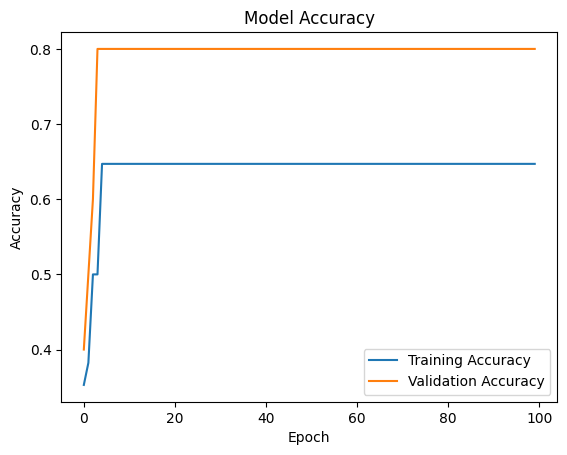

In [ ]:
# Plot training history
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save model
lstm_model.save('checkpoints/synthetic_data_lstm.h5')

In [ ]:
# Assuming cluster_labels is a pandas Series
unique_classes = pd.unique(cluster_labels)
print("Unique classes:", unique_classes)

# To get the number of unique classes
n_clusters = len(unique_classes)
print("Number of unique classes:", n_clusters)

predictions = lstm_model.predict(X_train_patient_level_scaled)
if n_clusters == 2:
    predicted_labels = (predictions > 0.5).astype(int)  # Apply threshold for binary classification
    predicted_labels = np.argmax(predicted_labels, axis=1)
else:
    predicted_labels = np.argmax(predictions, axis=1)  # Get class with highest probability for multi-class


Unique classes: [0 1]
Number of unique classes: 2


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Make predictions
# predictions = lstm_model.predict(X_train_patient_level_scaled)
# predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate F1 score
f1 = f1_score(cluster_labels, predicted_labels, average='weighted')
print(f"F1 Score for Synthetic Data: {f1}")

# Calculate precision
precision = precision_score(cluster_labels, predicted_labels, average='weighted')
print(f"Precision for Synthetic Data: {precision}")

# Calculate recall
recall = recall_score(cluster_labels, predicted_labels, average='weighted')
print(f"Recall for Synthetic Data: {recall}")


F1 Score for Synthetic Data: 0.5528255528255529
Precision for Synthetic Data: 0.4648760330578512
Recall for Synthetic Data: 0.6818181818181818


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# SHAP analysis
explainer_synthetic = shap.DeepExplainer(lstm_model, X_train_patient_level_scaled)
shap_values_synthetic = explainer_synthetic.shap_values(X_train_patient_level_scaled, check_additivity=False)

In [ ]:
# ARSHIAs CODE TO CORRECT ERROR IN ONE CELL BELOW
feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 0

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# No need to reshape here as the original shape is (features, 2)
# shap_average_abs_value = shap_average_abs_value.reshape(time_steps, -1).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array by taking the mean across the second dimension
shap_average_abs_value = shap_average_abs_value.mean(axis=1)

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Reshape shap_average_abs_value to match x_average_value_df
shap_average_abs_value = shap_average_abs_value.reshape(1, -1)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (1, 7)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
shap.initjs()
shap.force_plot(0, shap_average_abs_value, x_average_value_df)

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (660, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


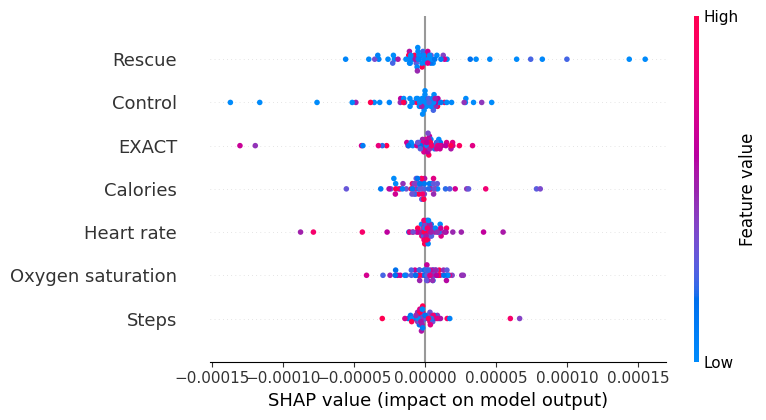

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

In [ ]:
# SHAP for Cluster 1 below

In [ ]:
# ARSHIAs CODE TO CORRECT ERROR IN ONE CELL BELOW
feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 1

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# No need to reshape here as the original shape is (features, 2)
# shap_average_abs_value = shap_average_abs_value.reshape(time_steps, -1).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array by taking the mean across the second dimension
shap_average_abs_value = shap_average_abs_value.mean(axis=1)

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Reshape shap_average_abs_value to match x_average_value_df
shap_average_abs_value = shap_average_abs_value.reshape(1, -1)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (1, 7)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
shap.initjs()
shap.force_plot(0, shap_average_abs_value, x_average_value_df)

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (660, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


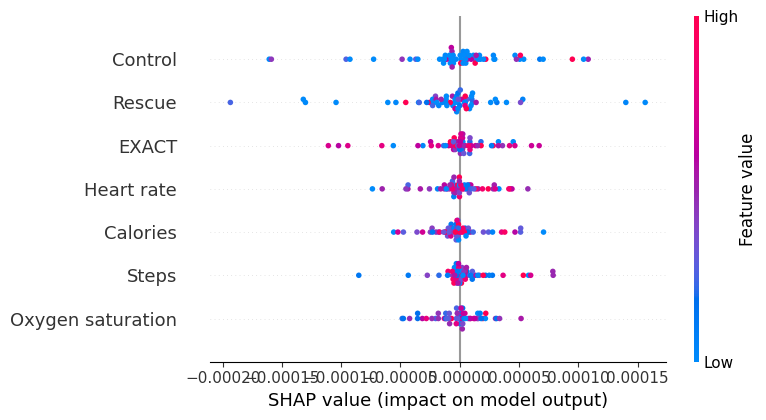

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

# Real Data

In [ ]:
# Load the real data
real_data = pd.read_csv('data_without_scaling/interpolated_exacerbation_data.csv')

# Define features
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
real_data

user_id  event_id  index      id  study_day  exact_computed  avg_ox_sat  \
0          0         0     40  7RNE74         40           37.00   92.269979   
1          0         0     41  7RNE74         41           37.01   92.269979   
2          0         0     42  7RNE74         42           37.00   92.269979   
3          0         0     43  7RNE74         43           37.02   92.269979   
4          0         0     44  7RNE74         44           37.00   92.269979   
..       ...       ...    ...     ...        ...             ...         ...   
655        7         2   3851  XKCKIT        126           47.00   91.020000   
656        7         2   3852  XKCKIT        127           50.00   91.000000   
657        7         2   3853  XKCKIT        128           51.00   91.020000   
658        7         2   3854  XKCKIT        129           57.00   91.000000   
659        7         2   3855  XKCKIT        130           52.00   91.020000   

     rescue  control  heart_rate     steps  calories  
0       0.0      0.0   82.575694  0.000000  1.311100  
1       4.0      0.0   81.528873  0.010000  1.321100  
2       4.0      0.0   79.950693  1.911111  1.759879  
3       2.0      0.0   80.088645  2.203472  1.858575  
4       4.0      0.0   81.156987  3.703472  2.003069  
..      ...      ...         ...       ...       ...  
655     0.0      0.0   72.416600  2.747917  1.229528  
656     0.0      0.0   71.983658  1.628472  1.143586  
657     0.0      0.0   73.874034  2.289583  1.207926  
658     0.0      0.0   70.013542  1.857639  1.157054  
659     0.0      0.0   71.828449  1.052778  1.117250  

[660 rows x 12 columns]

In [ ]:
# Prepare data for patient-level analysis
def prepare_patient_level_data(data):
    patient_level_data = []
    for (user, event), group in data.groupby(['id', 'event_id']):
        patient_level_data.append(group[features].values)
    return np.array(patient_level_data)

X_train_patient_level = prepare_patient_level_data(real_data)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_patient_level_2d = X_train_patient_level.reshape(-1, X_train_patient_level.shape[-1])
X_train_patient_level_2d_scaled = scaler.fit_transform(X_train_patient_level_2d)
X_train_patient_level_scaled = X_train_patient_level_2d_scaled.reshape(X_train_patient_level.shape)

In [ ]:
len(X_train_patient_level_scaled[0])

30

In [ ]:
# Save StandardScaler object
pickle.dump(scaler, open('checkpoints/real_data_scaler.pkl', 'wb'))

In [ ]:
# Load the pre-trained LSTM autoencoder
autoencoder = load_model('lstm_autoencoder.h5')

# Create the encoder model
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[3].output)

# LSTM Autoencoder for dimensionality reduction before applying KMeans clustering
encoded_vecs_patient_level = encoder.predict(X_train_patient_level_scaled)
encoded_vecs_patient_level

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[1.96182504e-02, 1.51613681e-02, 0.00000000e+00, 0.00000000e+00,
        1.05536707e-01, 1.39902338e-01, 0.00000000e+00, 4.96685095e-02],
       [3.98643501e-02, 3.77542973e-02, 0.00000000e+00, 0.00000000e+00,
        1.27892479e-01, 1.63740098e-01, 0.00000000e+00, 1.10088341e-01],
       [6.90100137e-08, 1.81065183e-02, 0.00000000e+00, 0.00000000e+00,
        1.60050899e-01, 1.55161574e-01, 0.00000000e+00, 7.65179247e-02],
       [5.64423992e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.33256197e-01, 1.33079737e-01, 0.00000000e+00, 2.73822099e-02],
       [7.45419513e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01263322e-01, 1.26156971e-01, 0.00000000e+00, 7.91675691e-03],
       [5.98834902e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.02590680e-01, 1.26735449e-01, 6.01813383e-07, 6.68738969e-03],
       [8.48397548e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11837476e-01, 1.23956569e-01, 0.00000000e+00, 2.

In [ ]:
def perform_kmeans_clustering(max_clusters=7):
    sum_of_squared_distances = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)

    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        # km = km.fit(data.reshape(data.shape[0], -1))
        # Fit the KMeans clustering object to the encoded patient-level data
        km = km.fit(encoded_vecs_patient_level)
        sum_of_squared_distances.append(km.inertia_)
        # silhouette_scores.append(silhouette_score(data.reshape(data.shape[0], -1), km.labels_))
        # Calculate and append the silhouette score
        silhouette_scores.append(silhouette_score(encoded_vecs_patient_level, km.labels_))

    # Plot elbow curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return K[np.argmax(silhouette_scores)]

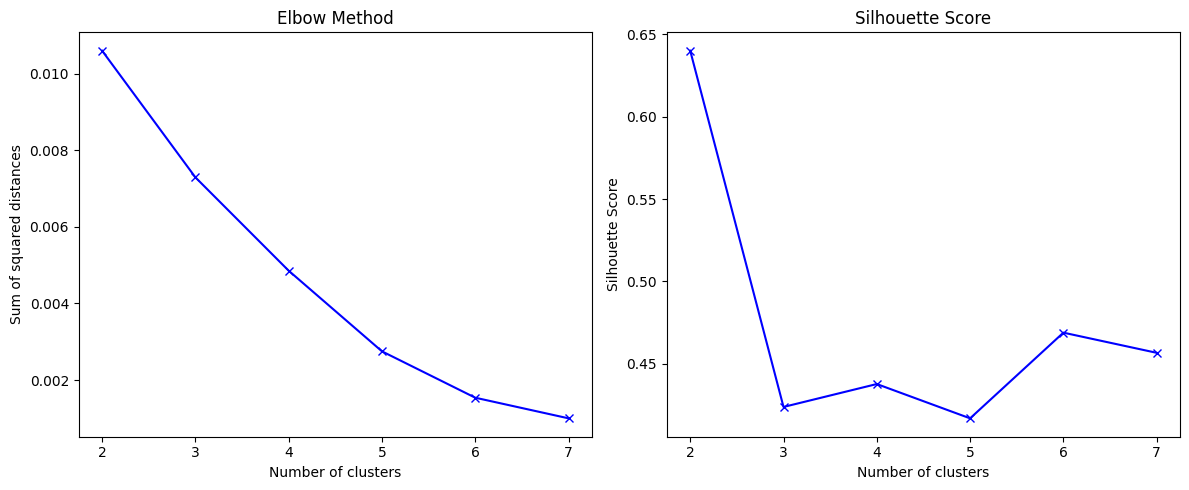

Optimal number of clusters: 2


In [ ]:
# Perform KMeans clustering
optimal_clusters = perform_kmeans_clustering()
print(f"Optimal number of clusters: {optimal_clusters}")

km_real = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = km_real.fit_predict(X_train_patient_level_scaled.reshape(X_train_patient_level_scaled.shape[0], -1))

real_centroids = km_real.cluster_centers_
real_labels = km_real.labels_

In [ ]:
cluster_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
real_centroids

array([[-0.87437547,  0.32243722, -0.60789722, -0.28686495,  0.19525107,
        -0.54796856, -1.13206219, -0.92478451,  0.16495993, -0.24048681,
        -0.35576265,  0.10595869, -0.60505594, -1.16027084, -0.84020558,
         0.32243722, -0.24048681, -0.42466035,  0.0762084 , -0.55366548,
        -1.14955435, -0.80637401,  0.2830679 , -0.24048681, -0.28686495,
         0.02379143, -0.68228674, -1.15525832, -0.92512283,  0.20590402,
        -0.34546121, -0.35576265, -0.06865229, -0.49889986, -1.11080286,
        -0.95793945,  0.1255906 , -0.29297401, -0.21796726, -0.13494743,
        -0.34423402, -1.08359891, -0.97587018,  0.1665347 , -0.50292281,
        -0.35576265,  0.22086376, -0.39667788, -1.04852561, -0.9244462 ,
         0.16495993, -0.34546121, -0.42466035,  0.32194434, -0.54867799,
        -0.9939047 , -0.92478451,  0.20590402, -0.60789722, -0.35576265,
         0.555189  , -0.56081349, -0.83076529, -0.89095294,  0.24448596,
        -0.50292281, -0.35576265,  0.69351885, -0.4

In [ ]:
real_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
# LSTM Model
def create_lstm_model(input_shape, n_clusters):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(8, activation='relu'),
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(n_clusters, activation='softmax' if n_clusters > 2 else 'sigmoid')
    ])

    optimizer = SGD(learning_rate=0.01, momentum=0.5, clipvalue=1.0)
    # Use sparse_categorical_crossentropy for all cases to handle integer labels
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# # Create and train LSTM model
lstm_model = create_lstm_model((X_train_patient_level_scaled.shape[1], X_train_patient_level_scaled.shape[2]), optimal_clusters)
history = lstm_model.fit(X_train_patient_level_scaled, cluster_labels, batch_size=32, epochs=100, validation_split=0.2)

Train on 17 samples, validate on 5 samples
Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.4706

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


17/17 [==============================] - 1s 85ms/sample - loss: 0.6932 - acc: 0.4706 - val_loss: 0.6912 - val_acc: 1.0000
Epoch 2/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6926 - acc: 0.5882 - val_loss: 0.6883 - val_acc: 1.0000
Epoch 3/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6917 - acc: 0.6471 - val_loss: 0.6849 - val_acc: 1.0000
Epoch 4/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6907 - acc: 0.6471 - val_loss: 0.6815 - val_acc: 1.0000
Epoch 5/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6897 - acc: 0.6471 - val_loss: 0.6781 - val_acc: 1.0000
Epoch 6/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.6887 - acc: 0.6471 - val_loss: 0.6745 - val_acc: 1.0000
Epoch 7/100
17/17 [==============================] - 0s 4ms/sample - loss: 0.6877 - acc: 0.6471 - val_loss: 0.6711 - val_acc: 1.0000
Epoch 8/100
17/17 [==============================] - 0s 3ms/sample - loss: 0.686

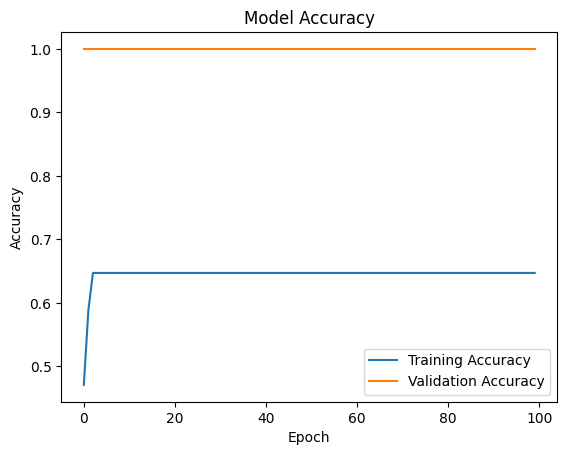

In [ ]:
# Plot training history
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save model
lstm_model.save('checkpoints/real_data_lstm.h5')

In [ ]:
# Assuming cluster_labels is a pandas Series
unique_classes = pd.unique(cluster_labels)
print("Unique classes:", unique_classes)

# To get the number of unique classes
n_clusters = len(unique_classes)
print("Number of unique classes:", n_clusters)

predictions = lstm_model.predict(X_train_patient_level_scaled)
if n_clusters == 2:
    predicted_labels = (predictions > 0.5).astype(int)  # Apply threshold for binary classification
    predicted_labels = np.argmax(predicted_labels, axis=1)
else:
    predicted_labels = np.argmax(predictions, axis=1)  # Get class with highest probability for multi-class


Unique classes: [1 0]
Number of unique classes: 2


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# # Make predictions
# predictions = lstm_model.predict(X_train_patient_level_scaled)
# predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate F1 score
f1 = f1_score(cluster_labels, predicted_labels, average='weighted')
print(f"F1 Score for Real Data: {f1}")

# Calculate precision
precision = precision_score(cluster_labels, predicted_labels, average='weighted')
print(f"Precision for Real Data: {precision}")

# Calculate recall
recall = recall_score(cluster_labels, predicted_labels, average='weighted')
print(f"Recall for Real Data: {recall}")

F1 Score for Real Data: 0.6124401913875598
Precision for Real Data: 0.5289256198347108
Recall for Real Data: 0.7272727272727273


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# SHAP analysis
explainer_synthetic = shap.DeepExplainer(lstm_model, X_train_patient_level_scaled)
shap_values_synthetic = explainer_synthetic.shap_values(X_train_patient_level_scaled, check_additivity=False)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:

feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 0

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# No need to reshape here as the original shape is (features, 2)
# shap_average_abs_value = shap_average_abs_value.reshape(time_steps, -1).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array by taking the mean across the second dimension
shap_average_abs_value = shap_average_abs_value.mean(axis=1)

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Reshape shap_average_abs_value to match x_average_value_df
shap_average_abs_value = shap_average_abs_value.reshape(1, -1)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (1, 7)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
shap.initjs()
shap.force_plot(0, shap_average_abs_value, x_average_value_df)

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (660, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


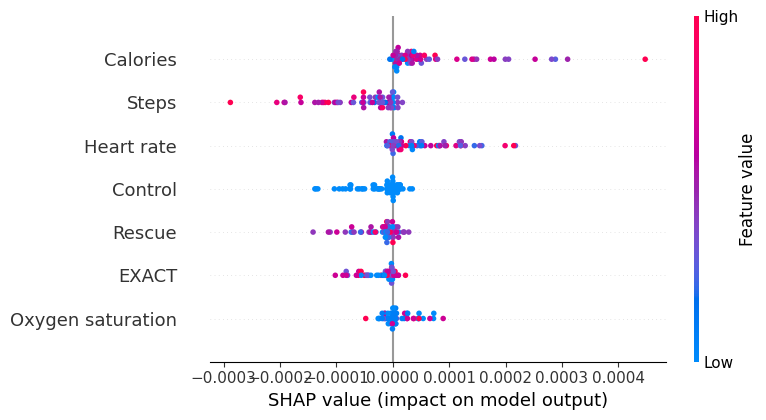

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

In [ ]:
# SHAP for cluster 1

In [ ]:

feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 1

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# No need to reshape here as the original shape is (features, 2)
# shap_average_abs_value = shap_average_abs_value.reshape(time_steps, -1).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array by taking the mean across the second dimension
shap_average_abs_value = shap_average_abs_value.mean(axis=1)

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Reshape shap_average_abs_value to match x_average_value_df
shap_average_abs_value = shap_average_abs_value.reshape(1, -1)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (1, 7)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
shap.initjs()
shap.force_plot(0, shap_average_abs_value, x_average_value_df)

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (660, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


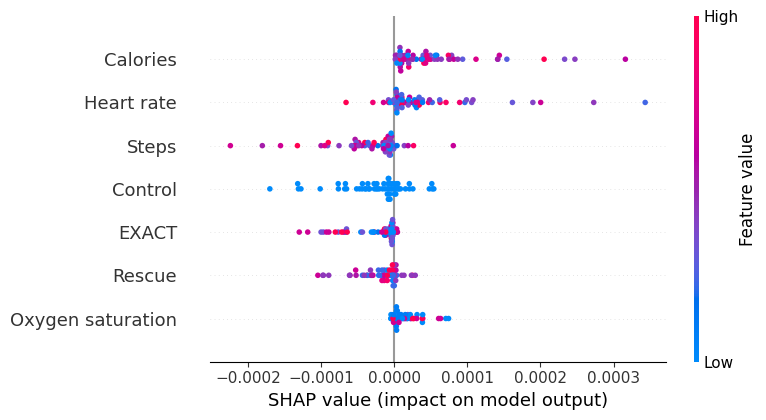

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

# Synthetic + Real Data

In [ ]:
import pandas as pd

# Read the CSV files
real_data = pd.read_csv('data_without_scaling/interpolated_exacerbation_data.csv')
synthetic_data = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')

# Rename the 'day' column in the synthetic data to 'study_day'
# synthetic_data = synthetic_data.rename(columns={'day': 'study_day'})

# Merge the real and synthetic data
merged_data = pd.DataFrame()
for id in set(real_data['id'].unique()) | set(synthetic_data['id'].unique()):
    real_events = real_data[real_data['id'] == id]
    synthetic_events = synthetic_data[synthetic_data['id'] == id]

    # Increment the 'event_id' in the synthetic data
    max_event_id = real_events['event_id'].max() if not real_events.empty else 0
    synthetic_events['event_id'] = synthetic_events['event_id'] + max_event_id + 1

    # Concatenate the real and synthetic data
    merged_data = pd.concat([merged_data, real_events, synthetic_events], ignore_index=True)

# Save the merged data to a new CSV file
merged_data.to_csv('merged_data_real_synthetic.csv', index=False)

<ipython-input-60-47cfe14e48bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_events['event_id'] = synthetic_events['event_id'] + max_event_id + 1
<ipython-input-60-47cfe14e48bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_events['event_id'] = synthetic_events['event_id'] + max_event_id + 1
<ipython-input-60-47cfe14e48bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
# Load the data
synthetic_real_data = pd.read_csv('merged_data_real_synthetic.csv')

# Define features
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
synthetic_real_data

user_id  event_id  index      id  study_day  exact_computed  avg_ox_sat  \
0         1.0         0  579.0  98RIV7        262       55.000000   93.000000   
1         1.0         0  580.0  98RIV7        263       53.000000   87.000000   
2         1.0         0  581.0  98RIV7        264       67.000000   92.000000   
3         1.0         0  582.0  98RIV7        265       64.000000   67.000000   
4         1.0         0  583.0  98RIV7        266       59.000000   91.000000   
...       ...       ...    ...     ...        ...             ...         ...   
1315      NaN         5    NaN  MMOGWL         26       33.271227   93.570184   
1316      NaN         5    NaN  MMOGWL         27       31.750910   93.196008   
1317      NaN         5    NaN  MMOGWL         28       37.805308   95.064636   
1318      NaN         5    NaN  MMOGWL         29       46.218021   91.689029   
1319      NaN         5    NaN  MMOGWL         30       45.200800   91.324574   

         rescue   control  heart_rate     steps  calories  
0      8.000000  0.000000   93.680492  0.000000  0.977700  
1     22.000000  1.000000   81.604420  0.338889  1.174191  
2      0.000000  1.000000   69.528347  0.071528  1.011716  
3      0.000000  1.000000   71.915972  0.145833  1.120485  
4      0.000000  1.000000   71.313399  0.248611  1.137255  
...         ...       ...         ...       ...       ...  
1315   0.075834  0.346187   74.683504  0.585832  0.936447  
1316   0.180589  0.032399   63.824001  0.435656  0.873508  
1317   1.553196  0.031120   73.466862  1.861066  1.839245  
1318   0.272233  0.018815   75.701038  2.993103  1.326578  
1319   0.166570  0.005440   71.619047  5.716278  1.456705  

[1320 rows x 12 columns]

In [ ]:
# Prepare data for patient-level analysis
def prepare_patient_level_data(data):
    patient_level_data = []
    for (user, event), group in data.groupby(['id', 'event_id']):
        patient_level_data.append(group[features].values)
    return np.array(patient_level_data)

X_train_patient_level = prepare_patient_level_data(synthetic_real_data)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_patient_level_2d = X_train_patient_level.reshape(-1, X_train_patient_level.shape[-1])
X_train_patient_level_2d_scaled = scaler.fit_transform(X_train_patient_level_2d)
X_train_patient_level_scaled = X_train_patient_level_2d_scaled.reshape(X_train_patient_level.shape)

In [ ]:
len(X_train_patient_level_scaled[0])

30

In [ ]:
# Save StandardScaler object
pickle.dump(scaler, open('checkpoints/synthetic_real_data_scaler.pkl', 'wb'))

In [ ]:
# Load the pre-trained LSTM autoencoder
autoencoder = load_model('lstm_autoencoder.h5')

# Create the encoder model
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[3].output)

# LSTM Autoencoder for dimensionality reduction before applying KMeans clustering
encoded_vecs_patient_level = encoder.predict(X_train_patient_level_scaled)
encoded_vecs_patient_level

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([[2.53320709e-02, 1.47321112e-02, 0.00000000e+00, 0.00000000e+00,
        9.96298790e-02, 1.41183600e-01, 0.00000000e+00, 5.19825220e-02],
       [3.94389108e-02, 2.99846828e-02, 0.00000000e+00, 0.00000000e+00,
        1.21177338e-01, 1.71779737e-01, 0.00000000e+00, 1.16794981e-01],
       [1.03170379e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.01953000e-01, 1.29673183e-01, 0.00000000e+00, 7.45192589e-03],
       [8.81219862e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11253925e-01, 1.30644917e-01, 0.00000000e+00, 1.38229271e-02],
       [7.24411535e-08, 2.34232955e-02, 0.00000000e+00, 0.00000000e+00,
        1.69325396e-01, 1.62901565e-01, 0.00000000e+00, 9.11896229e-02],
       [5.74230015e-08, 9.95845883e-04, 0.00000000e+00, 0.00000000e+00,
        1.39209017e-01, 1.36434436e-01, 0.00000000e+00, 3.25913653e-02],
       [7.17159523e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.08114690e-01, 1.30111381e-01, 0.00000000e+00, 1.

In [ ]:
def perform_kmeans_clustering(max_clusters=7):
    sum_of_squared_distances = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)

    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        # km = km.fit(data.reshape(data.shape[0], -1))
        # Fit the KMeans clustering object to the encoded patient-level data
        km = km.fit(encoded_vecs_patient_level)
        sum_of_squared_distances.append(km.inertia_)
        # silhouette_scores.append(silhouette_score(data.reshape(data.shape[0], -1), km.labels_))
        # Calculate and append the silhouette score
        silhouette_scores.append(silhouette_score(encoded_vecs_patient_level, km.labels_))

    # Plot elbow curve
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')

    # Plot silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return K[np.argmax(silhouette_scores)]

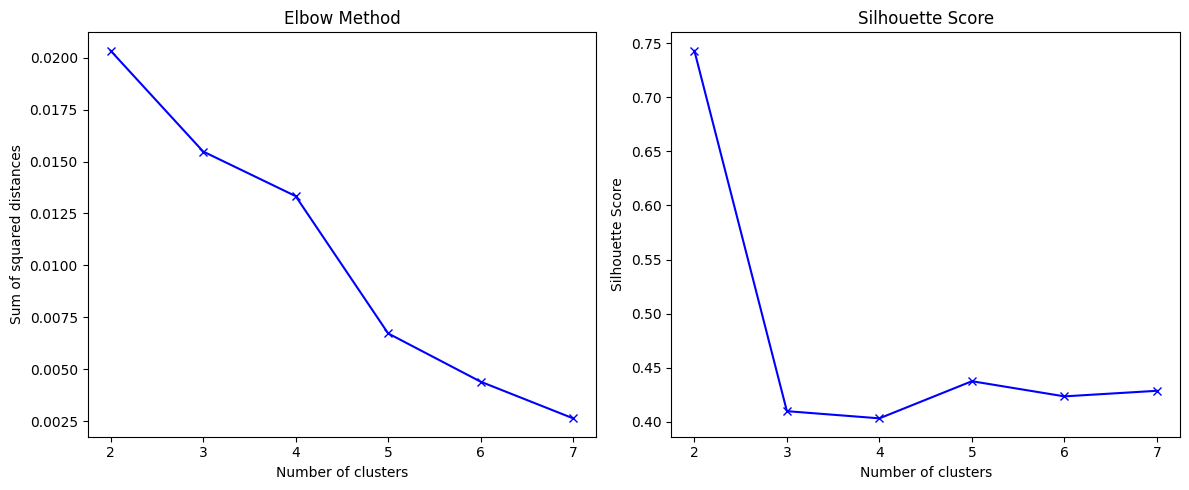

Optimal number of clusters: 2


In [ ]:
# Perform KMeans clustering
optimal_clusters = perform_kmeans_clustering()
print(f"Optimal number of clusters: {optimal_clusters}")

km_real_synth = KMeans(n_clusters=optimal_clusters, random_state=42)
km_real_synth.fit(X_train_patient_level_scaled.reshape(X_train_patient_level_scaled.shape[0], -1))

real_snth_centroids = km_real_synth.cluster_centers_  # Get cluster centroids
real_synth_labels = km_real_synth.labels_  # Get cluster labels



cluster_labels = km_real_synth.fit_predict(X_train_patient_level_scaled.reshape(X_train_patient_level_scaled.shape[0], -1))

In [ ]:
cluster_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
# LSTM Model
def create_lstm_model(input_shape, n_clusters):
    model = Sequential([
        LSTM(32, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(16, activation='relu', return_sequences=True),
        LSTM(8, activation='relu'),
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(n_clusters, activation='softmax' if n_clusters > 2 else 'sigmoid')
    ])

    optimizer = SGD(learning_rate=0.01, momentum=0.5, clipvalue=1.0)
    model.compile(loss='categorical_crossentropy' if n_clusters > 2 else 'binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Create and train LSTM model
lstm_model = create_lstm_model((X_train_patient_level_scaled.shape[1], X_train_patient_level_scaled.shape[2]), optimal_clusters)

# One-hot encode the cluster labels
cluster_labels_onehot = to_categorical(cluster_labels)

history = lstm_model.fit(X_train_patient_level_scaled, cluster_labels_onehot, batch_size=32, epochs=100, validation_split=0.2)

Train on 35 samples, validate on 9 samples
Epoch 1/100
32/35 [==========================>...] - ETA: 0s - loss: 0.6931 - acc: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


35/35 [==============================] - 2s 55ms/sample - loss: 0.6929 - acc: 0.5571 - val_loss: 0.6903 - val_acc: 0.7778
Epoch 2/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6910 - acc: 0.8286 - val_loss: 0.6857 - val_acc: 1.0000
Epoch 3/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6879 - acc: 0.8286 - val_loss: 0.6805 - val_acc: 1.0000
Epoch 4/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6845 - acc: 0.8286 - val_loss: 0.6752 - val_acc: 1.0000
Epoch 5/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6808 - acc: 0.8000 - val_loss: 0.6693 - val_acc: 1.0000
Epoch 6/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6768 - acc: 0.8143 - val_loss: 0.6639 - val_acc: 1.0000
Epoch 7/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.6732 - acc: 0.8143 - val_loss: 0.6589 - val_acc: 1.0000
Epoch 8/100
35/35 [==============================] - 0s 4ms/sample - loss: 0.669

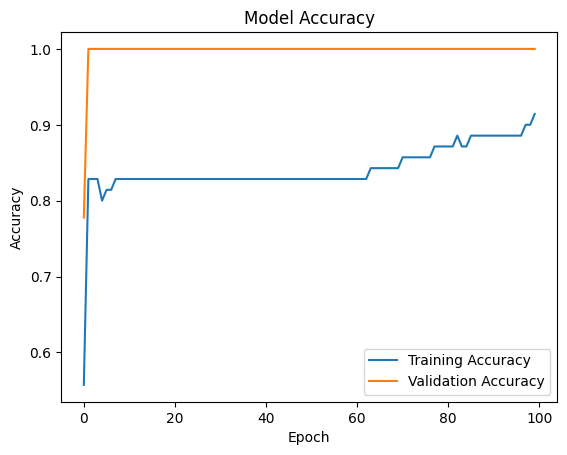

In [ ]:
# Plot training history
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Save model
lstm_model.save('checkpoints/synthetic_real_data_lstm.h5')

In [ ]:
# Assuming cluster_labels is a pandas Series
unique_classes = pd.unique(cluster_labels)
print("Unique classes:", unique_classes)

# To get the number of unique classes
n_clusters = len(unique_classes)
print("Number of unique classes:", n_clusters)

predictions = lstm_model.predict(X_train_patient_level_scaled)
if n_clusters == 2:
    predicted_labels = (predictions > 0.5).astype(int)  # Apply threshold for binary classification
    predicted_labels = np.argmax(predicted_labels, axis=1)
else:
    predicted_labels = np.argmax(predictions, axis=1)  # Get class with highest probability for multi-class


Unique classes: [1 0]
Number of unique classes: 2


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# # Make predictions
# predictions = lstm_model.predict(X_train_patient_level_scaled)
# predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate F1 score
f1 = f1_score(cluster_labels, predicted_labels, average='weighted')
print(f"F1 Score for R+S Data: {f1}")

# Calculate precision
precision = precision_score(cluster_labels, predicted_labels, average='weighted')
print(f"Precision for R+S Data: {precision}")

# Calculate recall
recall = recall_score(cluster_labels, predicted_labels, average='weighted')
print(f"Recall for R+S Data: {recall}")

F1 Score for R+S Data: 0.9505827505827504
Precision for R+S Data: 0.9568181818181819
Recall for R+S Data: 0.9545454545454546


In [ ]:
# SHAP analysis
explainer_synthetic = shap.DeepExplainer(lstm_model, X_train_patient_level_scaled)
shap_values_synthetic = explainer_synthetic.shap_values(X_train_patient_level_scaled, check_additivity=False)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [ ]:
feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 0

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array
shap_average_abs_value = shap_average_abs_value.flatten()

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (14,)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
#shap.initjs()
#shap.force_plot(0, shap_average_abs_value, x_average_value_df)

DimensionError: Length of features is not equal to the length of shap_values!

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (1320, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


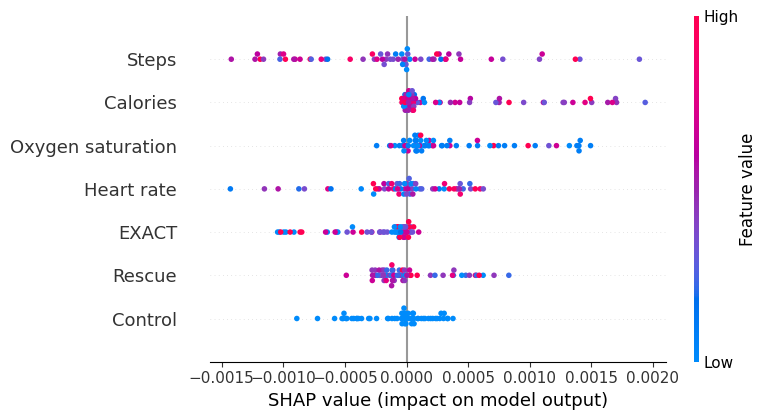

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

In [ ]:
feature_columns_training = ["EXACT", "Oxygen saturation", "Rescue", "Control", "Heart rate", "Steps", "Calories"]

cluster_id = 1

# Calculate the average absolute SHAP values
shap_average_abs_value = np.abs(shap_values_synthetic[cluster_id]).mean(axis=0)

# Reshape to (time_steps, features) and then average across time steps
time_steps = 2  # Adjust this based on your actual number of time steps
shap_average_abs_value = shap_average_abs_value.reshape(time_steps, -1).mean(axis=0)

# Ensure shap_average_abs_value is a 1D array
shap_average_abs_value = shap_average_abs_value.flatten()

# Calculate average feature values
x_average_value = X_train_patient_level_scaled.mean(axis=(0, 1))

# Create a DataFrame with the correct shape
x_average_value_df = pd.DataFrame([x_average_value], columns=feature_columns_training)

# Reshape shap_average_abs_value to match x_average_value_df
shap_average_abs_value = shap_average_abs_value.reshape(1, -1)

# Print shapes for debugging
print("Shape of shap_average_abs_value:", shap_average_abs_value.shape)
print("Shape of x_average_value_df:", x_average_value_df.shape)

Shape of shap_average_abs_value: (1, 7)
Shape of x_average_value_df: (1, 7)


In [ ]:
# Create the force plot
shap.initjs()
shap.force_plot(0, shap_average_abs_value, x_average_value_df)

Shape of shap_values_2D: (60, 7)
Shape of X_test_2D: (1320, 7)
Final shape of shap_values_2D: (60, 7)
Final shape of x_test_2d: (60, 7)


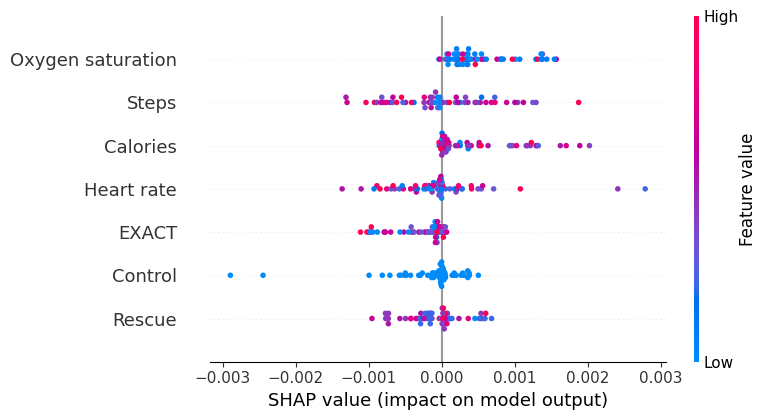

In [ ]:
# Reshape shap_values_synthetic and X_train_patient_level_scaled
shap_values_2D = shap_values_synthetic[cluster_id].reshape(-1, 7)
X_test_2D = X_train_patient_level_scaled.reshape(-1, 7)

# Print shapes for debugging
print("Shape of shap_values_2D:", shap_values_2D.shape)
print("Shape of X_test_2D:", X_test_2D.shape)

# Create DataFrame
x_test_2d = pd.DataFrame(data=X_test_2D, columns=feature_columns_training)

# Ensure shap_values_2D and x_test_2d have the same number of rows
min_rows = min(shap_values_2D.shape[0], x_test_2d.shape[0])
shap_values_2D = shap_values_2D[:min_rows, :]
x_test_2d = x_test_2d.iloc[:min_rows, :]

# Print final shapes
print("Final shape of shap_values_2D:", shap_values_2D.shape)
print("Final shape of x_test_2d:", x_test_2d.shape)

# Plot the SHAP summary plot
shap.summary_plot(shap_values_2D, x_test_2d)

# LSTM Inference Code For Real/ Interpolated Data

Real Data

In [ ]:
# Load the pre-trained model
model = load_model('checkpoints/real_data_lstm.h5')

# Load the scaler used during training
scaler = StandardScaler()
scaler = pickle.load(open('checkpoints/real_data_scaler.pkl', 'rb'))

# Define the features used in training
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

*italicized text*# New Section

In [ ]:
def predict_cluster(event_data):
    """
    Predicts the cluster for 30 days of event data.

    :param event_data: DataFrame containing 30 days of event data
    :return: Predicted cluster ID
    """
    # Ensure the data has exactly 30 rows
    # if len(event_data) != 30:
    #     raise ValueError("Event data must contain exactly 30 days of data")

    # Extract relevant features
    X = event_data[features].values

    # Scale the features
    X_scaled = scaler.transform(X)

    # Reshape for LSTM input (assuming the model expects this shape)
    X_reshaped = X_scaled.reshape(1, 30, len(features))

    # Make prediction
    prediction = model.predict(X_reshaped)

    # Get the cluster with highest probability
    cluster_id = np.argmax(prediction)

    return cluster_id

In [ ]:
# Load the CSV file
# df = pd.read_csv('30_day_event_data_for_inference.csv')

df = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')

# Group the data by id and event_id
grouped = df.groupby(['id', 'event_id'])

cluster_results = []

for (user_id, event_id), event_data in grouped:
    if len(event_data) == 30:  # Ensure we have 30 days of data
        cluster = predict_cluster(event_data)
        cluster_results.append({
            'id': user_id,
            'event_id': event_id,
            'cluster': cluster
        })
    else:
        print(f"Skipping event for user {user_id}, event {event_id}: Insufficient data")

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(cluster_results)

# Save results to CSV
results_df.to_csv('cluster_predictions_real.csv', index=False)

print("Cluster predictions saved to 'cluster_predictions_real.csv'")

Cluster predictions saved to 'cluster_predictions_real.csv'


In [ ]:
# Prepare data for plotting

from sklearn.decomposition import PCA

X = df[features].values
X_scaled = scaler.transform(X)

# Reduce dimensionality for plotting
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Create a mapping of (id, event_id) to cluster
cluster_map = results_df.set_index(['id', 'event_id'])['cluster'].to_dict()

# Assign clusters to the reduced data points
clusters = [cluster_map.get((row['id'], row['event_id']), -1) for _, row in df.iterrows()]

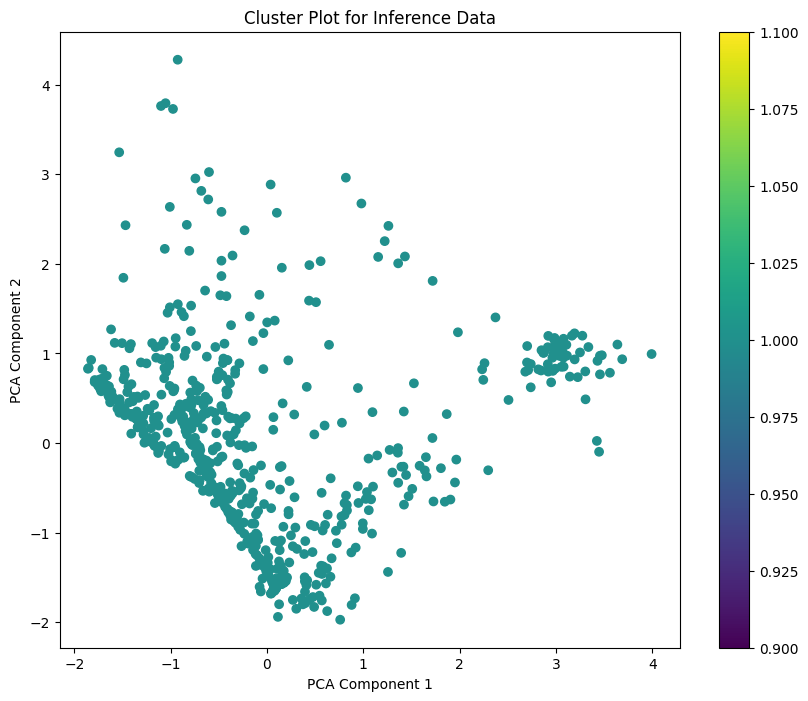

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Cluster Plot for Inference Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# LSTM INference code for Synthetic Data using real h5

In [ ]:
# Load the pre-trained model
model = load_model('checkpoints/real_data_lstm.h5')

# Load the scaler used during training
scaler = StandardScaler()
scaler = pickle.load(open('checkpoints/synthetic_data_scaler.pkl', 'rb'))

# Define the features used in training
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
def predict_cluster(event_data):
    """
    Predicts the cluster for 30 days of event data.

    :param event_data: DataFrame containing 30 days of event data
    :return: Predicted cluster ID
    """
    # Ensure the data has exactly 30 rows
    # if len(event_data) != 30:
    #     raise ValueError("Event data must contain exactly 30 days of data")

    # Extract relevant features
    X = event_data[features].values

    # Scale the features
    X_scaled = scaler.transform(X)

    # Reshape for LSTM input (assuming the model expects this shape)
    X_reshaped = X_scaled.reshape(1, 30, len(features))

    # Make prediction
    prediction = model.predict(X_reshaped)

    # Get the cluster with highest probability
    cluster_id = np.argmax(prediction)

    return cluster_id

In [ ]:
# Load the CSV file
# df = pd.read_csv('30_day_event_data_for_inference.csv')

df = pd.read_csv('synthetic_copd_data_six_events_all_users.csv')

# Group the data by id and event_id
grouped = df.groupby(['id', 'event_id'])

cluster_results = []

for (user_id, event_id), event_data in grouped:
    if len(event_data) == 30:  # Ensure we have 30 days of data
        cluster = predict_cluster(event_data)
        cluster_results.append({
            'id': user_id,
            'event_id': event_id,
            'cluster': cluster
        })
    else:
        print(f"Skipping event for user {user_id}, event {event_id}: Insufficient data")

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(cluster_results)

# Save results to CSV
results_df.to_csv('cluster_predictions_synth.csv', index=False)

print("Cluster predictions saved to 'cluster_predictions_synth.csv'")

Cluster predictions saved to 'cluster_predictions_synth.csv'


In [ ]:
# Prepare data for plotting
X = df[features].values
X_scaled = scaler.transform(X)

# Reduce dimensionality for plotting
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Create a mapping of (id, event_id) to cluster
cluster_map = results_df.set_index(['id', 'event_id'])['cluster'].to_dict()

# Assign clusters to the reduced data points
clusters = [cluster_map.get((row['id'], row['event_id']), -1) for _, row in df.iterrows()]

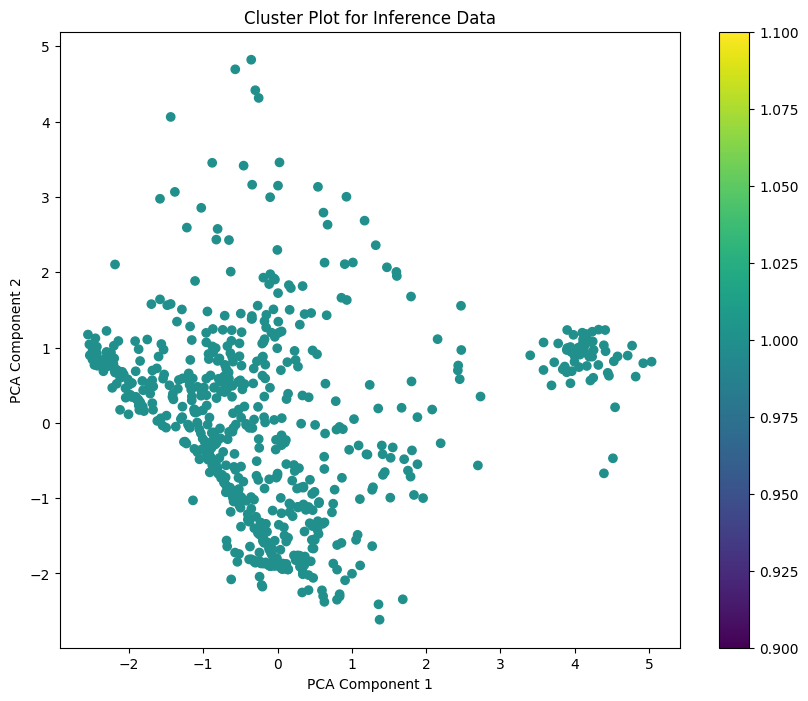

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Cluster Plot for Inference Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# LSTN inference code for Real+Synthetic Data using real h5


In [ ]:
# Load the pre-trained model
model = load_model('checkpoints/real_data_lstm.h5')

# Load the scaler used during training
scaler = StandardScaler()
scaler = pickle.load(open('checkpoints/synthetic_real_data_scaler.pkl', 'rb'))

# Define the features used in training
features = ['exact_computed', 'avg_ox_sat', 'rescue', 'control', 'heart_rate', 'steps', 'calories']

In [ ]:
def predict_cluster(event_data):
    """
    Predicts the cluster for 30 days of event data.

    :param event_data: DataFrame containing 30 days of event data
    :return: Predicted cluster ID
    """
    # Ensure the data has exactly 30 rows
    # if len(event_data) != 30:
    #     raise ValueError("Event data must contain exactly 30 days of data")

    # Extract relevant features
    X = event_data[features].values

    # Scale the features
    X_scaled = scaler.transform(X)

    # Reshape for LSTM input (assuming the model expects this shape)
    X_reshaped = X_scaled.reshape(1, 30, len(features))

    # Make prediction
    prediction = model.predict(X_reshaped)

    # Get the cluster with highest probability
    cluster_id = np.argmax(prediction)

    return cluster_id

In [ ]:
# Load the CSV file
# df = pd.read_csv('30_day_event_data_for_inference.csv')

df = pd.read_csv('merged_data_real_synthetic.csv')

# Group the data by id and event_id
grouped = df.groupby(['id', 'event_id'])

cluster_results = []

for (user_id, event_id), event_data in grouped:
    if len(event_data) == 30:  # Ensure we have 30 days of data
        cluster = predict_cluster(event_data)
        cluster_results.append({
            'id': user_id,
            'event_id': event_id,
            'cluster': cluster
        })
    else:
        print(f"Skipping event for user {user_id}, event {event_id}: Insufficient data")

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(cluster_results)

# Save results to CSV
results_df.to_csv('cluster_predictions_realplussynth.csv', index=False)

print("Cluster predictions saved to 'cluster_predictions_realplussynth.csv'")

Cluster predictions saved to 'cluster_predictions_realplussynth.csv'


In [ ]:
# Prepare data for plotting
X = df[features].values
X_scaled = scaler.transform(X)

# Reduce dimensionality for plotting
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Create a mapping of (id, event_id) to cluster
cluster_map = results_df.set_index(['id', 'event_id'])['cluster'].to_dict()

# Assign clusters to the reduced data points
clusters = [cluster_map.get((row['id'], row['event_id']), -1) for _, row in df.iterrows()]

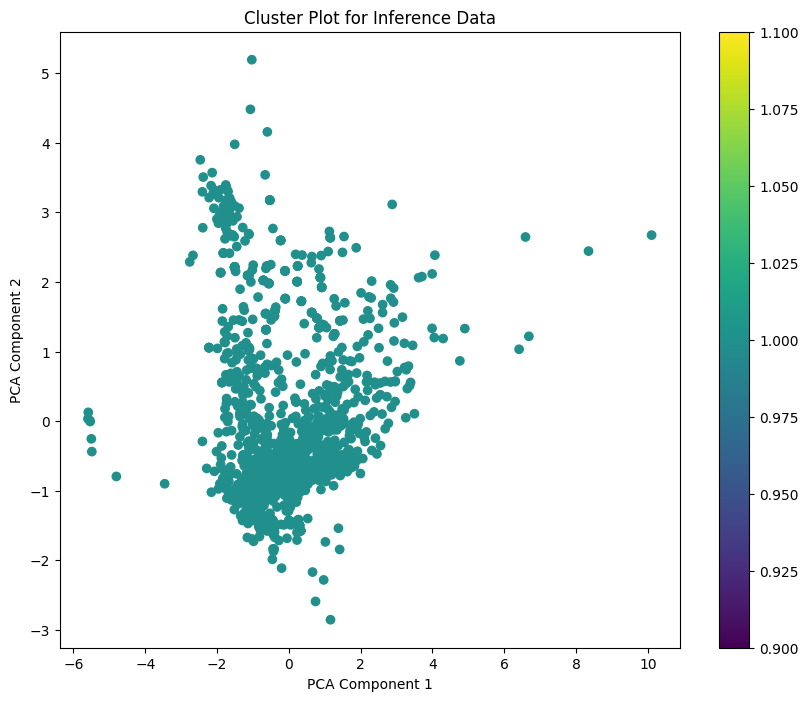

In [ ]:
# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('Cluster Plot for Inference Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()